# I. Preface

Objective: This document was made to build a clustering model that segment customers based on their behaviours of personalities.

---

# II. Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
# Statistical analysis
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
# Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
# Machine learning
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import silhouette_score,silhouette_samples
from kmodes.kprototypes import KPrototypes
# Timing
import time
# Serialization
import pickle
import json
# disable warnings
import warnings
warnings.filterwarnings('ignore') #turn off warning
import datetime as dt

---

# III. Data Loading

In [2]:
# Loading the cleaned csv dataset

df = pd.read_csv("data_cleaned.csv", index_col=False)

In [3]:
df.head()

Unnamed: 0    id  year_birth   education marital_status   income  kidhome  \
0           0  5524        1957  Graduation         Single  58138.0        0   
1           1  2174        1954  Graduation         Single  46344.0        1   
2           2  4141        1965  Graduation       Together  71613.0        0   
3           3  6182        1984  Graduation       Together  26646.0        1   
4           4  5324        1981         PhD        Married  58293.0        1   

   teenhome dt_customer  recency  ...  num_catalog_purchases  \
0         0  04-09-2012       58  ...                     10   
1         1  08-03-2014       38  ...                      1   
2         0  21-08-2013       26  ...                      2   
3         0  10-02-2014       26  ...                      0   
4         0  19-01-2014       94  ...                      3   

   num_store_purchases  num_web_visits_month  accepted_cmp3  accepted_cmp4  \
0                    4                     7              0              0   
1                    2                     5              0              0   
2                   10                     4              0              0   
3                    4                     6              0              0   
4                    6                     5              0              0   

   accepted_cmp5  accepted_cmp1  accepted_cmp2  complain  response  
0              0              0              0         0         1  
1              0              0              0         0         0  
2              0              0              0         0         0  
3              0              0              0         0         0  
4              0              0              0         0         0  

[5 rows x 28 columns]

dataset successfully loaded.

---

# IV. Feature Engineering

## 1. Feature Creation

In [4]:
## Only non responding customer
df = df[df['response'] == 0]

In [5]:
# Create new features from amount features
df["total_mnt"] = df["mnt_wines"] + df["mnt_fruits"] + df["mnt_meat_products"] + df["mnt_fish_products"] + df["mnt_sweet_products"] + df["mnt_gold_prods"]

In [6]:
# Filter out rows where year_birth is less than 1928
df = df[df["year_birth"] >= 1928]

# Define generation labels and ranges
generations = {
    "Silent Generation": (1928, 1945),
    "Baby Boomers": (1946, 1964),
    "Generation X": (1965, 1980),
    "Millennials": (1981, 1996),
    "Generation Z": (1997, 2012),
    "Generation Alpha": (2013, 2025)
}

# Create a function to assign generation label
def assign_generation(year):
    for gen, (start, end) in generations.items():
        if start <= year <= end:
            return gen
    return "Unknown"

# Apply the function to the year_birth feature
df["generation"] = df["year_birth"].apply(assign_generation)

In [7]:
df["dt_customer"] = pd.to_datetime(df["dt_customer"], format="%d-%m-%Y")

# Create new features from date features
df["customer_since"] = (dt.datetime(2015, 1, 1) - df["dt_customer"]).dt.days

In [8]:
# Drop unnecessary columns
df = df.drop(["Unnamed: 0", "id", "dt_customer", "response"], axis=1) ## these columns won't help the model

In [9]:
df.head()

year_birth   education marital_status   income  kidhome  teenhome  recency  \
1        1954  Graduation         Single  46344.0        1         1       38   
2        1965  Graduation       Together  71613.0        0         0       26   
3        1984  Graduation       Together  26646.0        1         0       26   
4        1981         PhD        Married  58293.0        1         0       94   
5        1967      Master       Together  62513.0        0         1       16   

   mnt_wines  mnt_fruits  mnt_meat_products  ...  num_web_visits_month  \
1         11           1                  6  ...                     5   
2        426          49                127  ...                     4   
3         11           4                 20  ...                     6   
4        173          43                118  ...                     5   
5        520          42                 98  ...                     6   

   accepted_cmp3  accepted_cmp4  accepted_cmp5  accepted_cmp1  accepted_cmp2  \
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   
5              0              0              0              0              0   

   complain  total_mnt    generation  customer_since  
1         0         27  Baby Boomers             299  
2         0        776  Generation X             498  
3         0         53   Millennials             325  
4         0        422   Millennials             347  
5         0        716  Generation X             479  

[5 rows x 27 columns]

## 3. Split Columns

In [10]:
X_num = df[['income',
        'kidhome',
        'teenhome',
        'recency',
        'mnt_wines',
        'mnt_fruits',
        'mnt_meat_products',
        'mnt_fish_products',
        'mnt_sweet_products',
        'mnt_gold_prods',
        'num_deals_purchases',
        'num_web_purchases',
        'num_catalog_purchases',
        'num_store_purchases',
        'num_web_visits_month',
        'total_mnt',
        'customer_since']]
X_cat = df[[ 'education',
        'marital_status',
        'accepted_cmp1',
        'accepted_cmp2',
        'accepted_cmp3',
        'accepted_cmp4',
        'accepted_cmp5',
        'complain',
        'generation']]

In [11]:
X_num.shape

(1880, 17)

In [12]:
X_cat.shape

(1880, 9)

## 2. Outlier Handling

Just like the classification model, I'm handling the outliers of only income column.

In [13]:
def calculate_zscores(data_frame, column_name):
    """
    Calculate z-scores for a specific column in a DataFrame.
    """
    # Calculate mean and standard deviation
    mean_value = data_frame[column_name].mean()
    std_dev = data_frame[column_name].std()

    # Calculate z-scores
    z_scores = (data_frame[column_name] - mean_value) / std_dev

    return z_scores

In [14]:
def remove_outliers_zscore(data_frame, column_name, z_threshold=3):
    """
    Remove outliers from a specified column of a DataFrame using z-scores.
    """
    # Calculate z-scores
    z_scores = calculate_zscores(data_frame, column_name)

    # Identify outliers based on z-scores
    outliers = data_frame[abs(z_scores) > z_threshold]

    # Remove outliers from the DataFrame
    data_frame_no_outliers = data_frame[abs(z_scores) <= z_threshold]

    return data_frame_no_outliers

X_num = remove_outliers_zscore(X_num, 'income')
X_cat = X_cat.loc[X_num.index]
df = df.loc[X_num.index]

In [15]:
X_num.shape

(1872, 17)

In [16]:
X_cat.shape

(1872, 9)

## 3. Feature Scaling

In [17]:
scaler = StandardScaler()
scaler.fit(X_num)

StandardScaler()

In [18]:
X_num_scaled = scaler.transform(X_num)

## 4. Encoding

In [19]:
def encoder(df):
    # Define the mappings for each variable
    education_mapping = {'PhD': 0, 'Basic': 1, 'Graduation': 2, 'Master': 3, '2n Cycle': 4}
    marital_status_mapping = {'Together': 0, 'Married': 1, 'Single': 2, 'Divorced': 3, 'Widow': 4, 'Alone': 5, 'YOLO': 6, 'Absurd': 7}
    binary_mapping = {0: 0, 1: 1}
    generation_mapping = {'Silent Generation':0, 'Baby Boomers': 1, 'Millennials': 2, 'Generation X': 3}

    # Apply the mappings to the DataFrame
    df['education'] = df['education'].map(education_mapping)
    df['marital_status'] = df['marital_status'].map(marital_status_mapping)
    df['accepted_cmp1'] = df['accepted_cmp1'].map(binary_mapping)
    df['accepted_cmp2'] = df['accepted_cmp2'].map(binary_mapping)
    df['accepted_cmp3'] = df['accepted_cmp3'].map(binary_mapping)
    df['accepted_cmp4'] = df['accepted_cmp4'].map(binary_mapping)
    df['accepted_cmp5'] = df['accepted_cmp5'].map(binary_mapping)
    df['complain'] = df['complain'].map(binary_mapping)
    df['generation'] = df['generation'].map(generation_mapping)

    return df

# Apply the function to the training and test data
X_cat_encoded = encoder(X_cat)

## 5. PCA

In [20]:
X_num_scaled_df = pd.DataFrame(X_num_scaled, columns=X_num.columns)

In [21]:
pca = PCA()
pca.fit(X_num_scaled_df)

PCA()

Text(0, 0.5, 'Explained Variance Ratio - Cummulative')

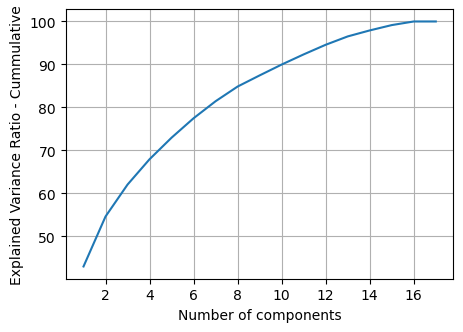

In [22]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=[5, 3.5])
plt.grid()
plt.plot(range(1, 18), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

In [23]:
# Check the number of features if we want to retain 95 % of the information
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

13

In [24]:
# Create the PCA
pca = PCA(n_components=13)
# fit and transform the PCA
pca.fit(X_num_scaled_df)
X_num_reduced = pca.transform(X_num_scaled_df)

## 6. Combine

In [25]:
X_final = np.concatenate([X_num_reduced, X_cat_encoded],axis=1)

In [26]:
X_final

array([[-2.48520974, -0.71103953, -1.23407831, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.14367615, -0.46971558, -0.31418817, ...,  0.        ,
         0.        ,  3.        ],
       [-2.61660678, -1.11316827,  0.01369172, ...,  0.        ,
         0.        ,  2.        ],
       ...,
       [-1.26954001,  2.32133722, -1.00583859, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.99057867, -0.66213422, -0.23837427, ...,  0.        ,
         0.        ,  2.        ],
       [ 2.35171995,  0.01596692, -1.89760886, ...,  0.        ,
         0.        ,  1.        ]])

---

# V. Clustering

## 1. Deciding K-values

### 1.1. Elbow Method

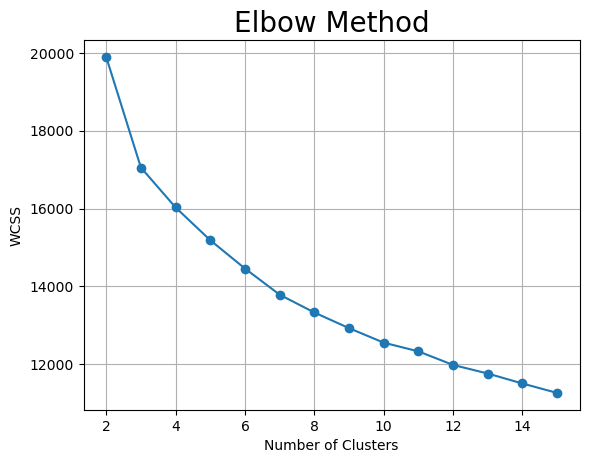

In [27]:
# Find the optimal number of clusters using Elbow Method
wcss = []
random_state = 10
max_cluster = 15
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 1000,
                n_init = 10,
                random_state = random_state)
    km.fit(X_num_reduced)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

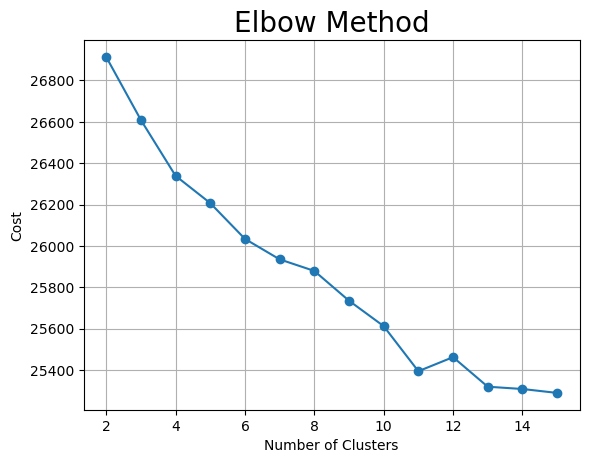

In [28]:
from kmodes.kmodes import KModes

# Find the optimal number of clusters using Elbow Method
cost = []
random_state = 10
max_cluster = 15
for i in range(2, max_cluster+1):
    km = KModes(n_clusters = i,
                init = 'Huang',
                  n_init = 10,
                  random_state = random_state)
    km.fit_predict(X_final)
    cost.append(km.cost_)

plt.plot(range(2, max_cluster+1), cost, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

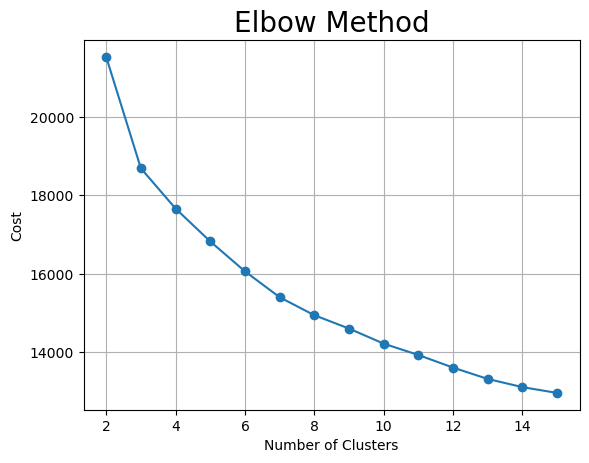

In [29]:
from kmodes.kprototypes import KPrototypes

# Find the optimal number of clusters using Elbow Method
cost = []
random_state = 10
max_cluster = 15
for i in range(2, max_cluster+1):
    kp = KPrototypes(n_clusters = i,
                    init = 'Huang',
                    n_init = 10,
                    random_state = random_state)
    kp.fit_predict(X_final, categorical=[13, 14, 15, 16, 17, 18, 19, 20, 21])
    cost.append(kp.cost_)

plt.plot(range(2, max_cluster+1), cost, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

### 1.2. Silhouette Method

In [30]:
# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.34000327092336796
For n_clusters = 3 The average silhouette_score is : 0.26170351577072504
For n_clusters = 4 The average silhouette_score is : 0.15774696961346357
For n_clusters = 5 The average silhouette_score is : 0.15301802672341083
For n_clusters = 6 The average silhouette_score is : 0.15182447906822402
For n_clusters = 7 The average silhouette_score is : 0.14532835209228664
For n_clusters = 8 The average silhouette_score is : 0.14359615889365868
For n_clusters = 9 The average silhouette_score is : 0.12902773086134692
For n_clusters = 10 The average silhouette_score is : 0.1305948206774593
For n_clusters = 11 The average silhouette_score is : 0.12844031060039057
For n_clusters = 12 The average silhouette_score is : 0.12856159334930004
For n_clusters = 13 The average silhouette_score is : 0.13006126667018095
For n_clusters = 14 The average silhouette_score is : 0.12854325946916045


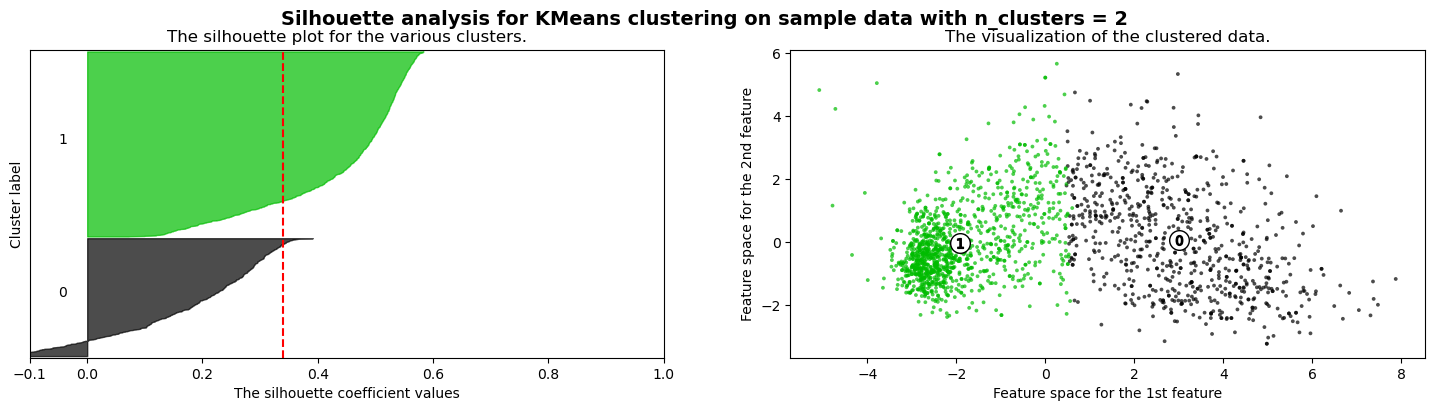

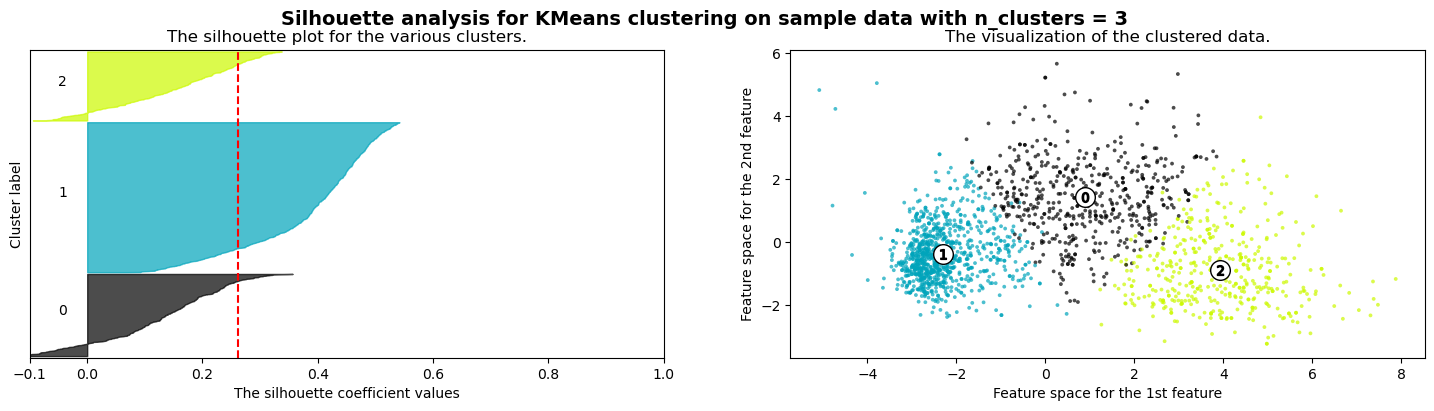

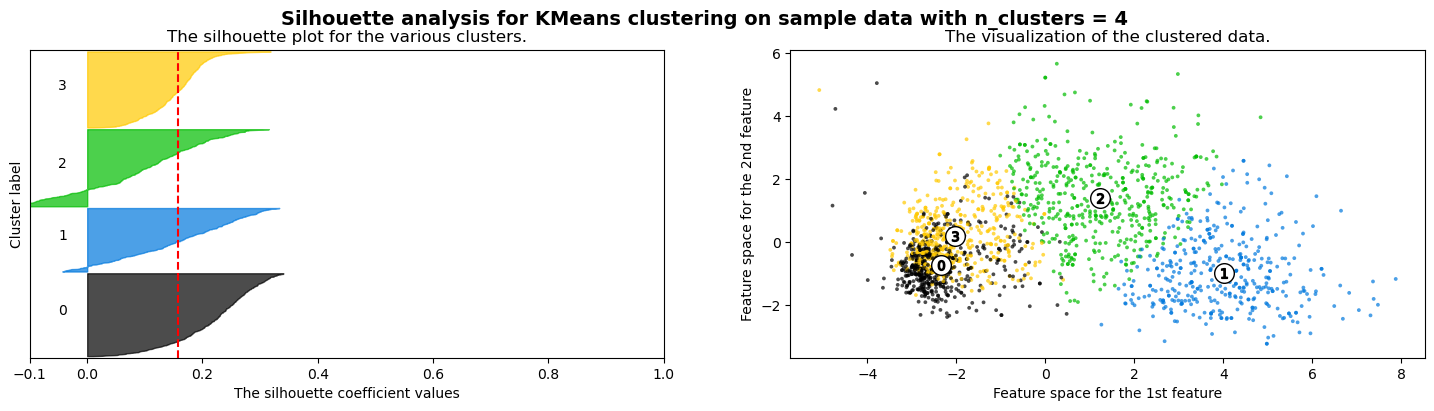

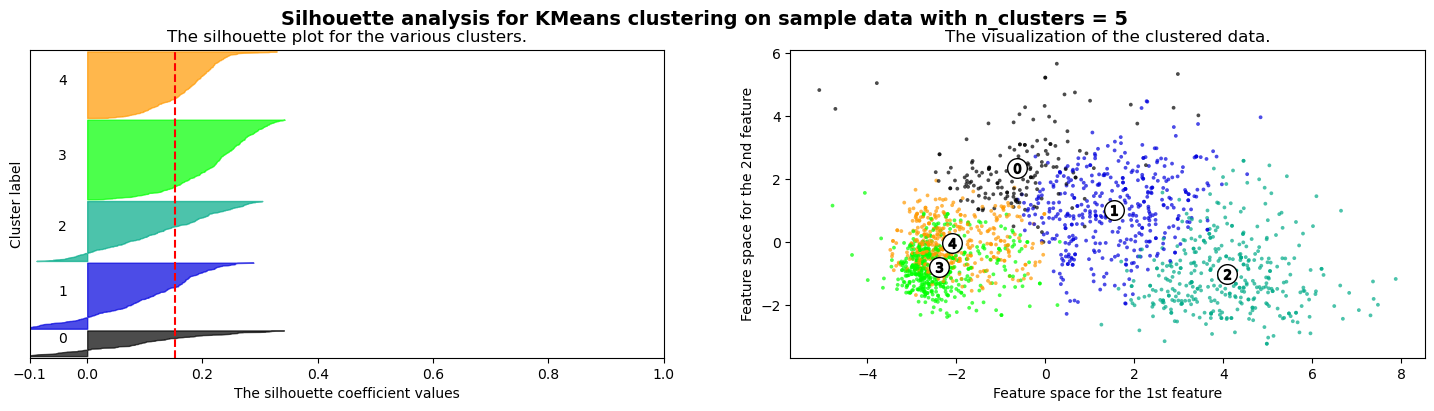

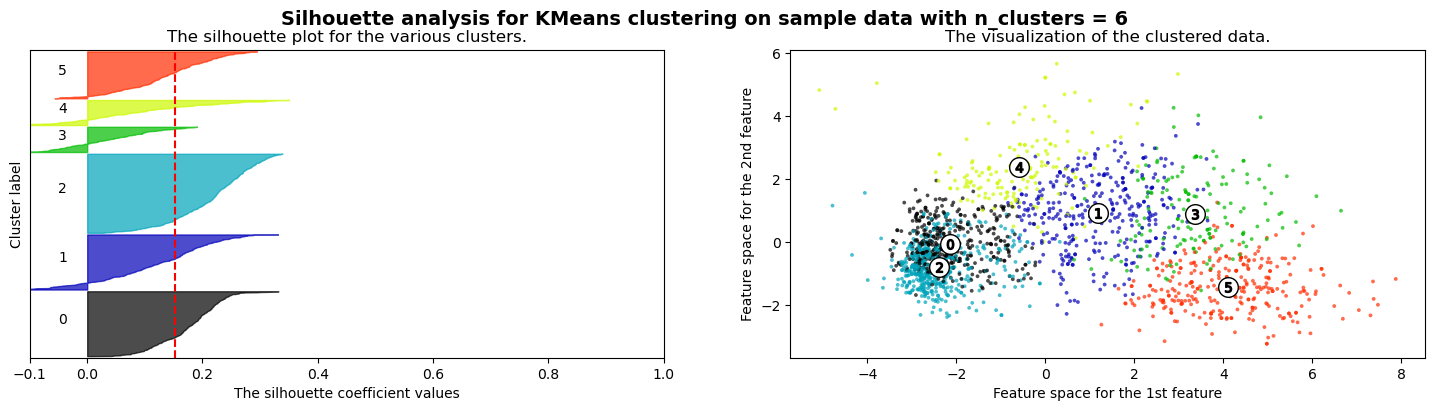

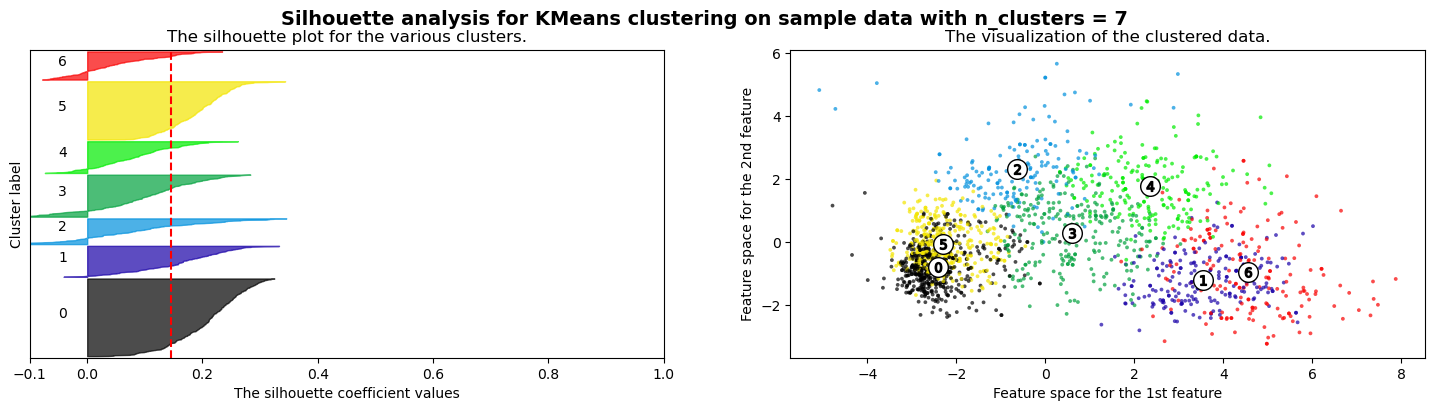

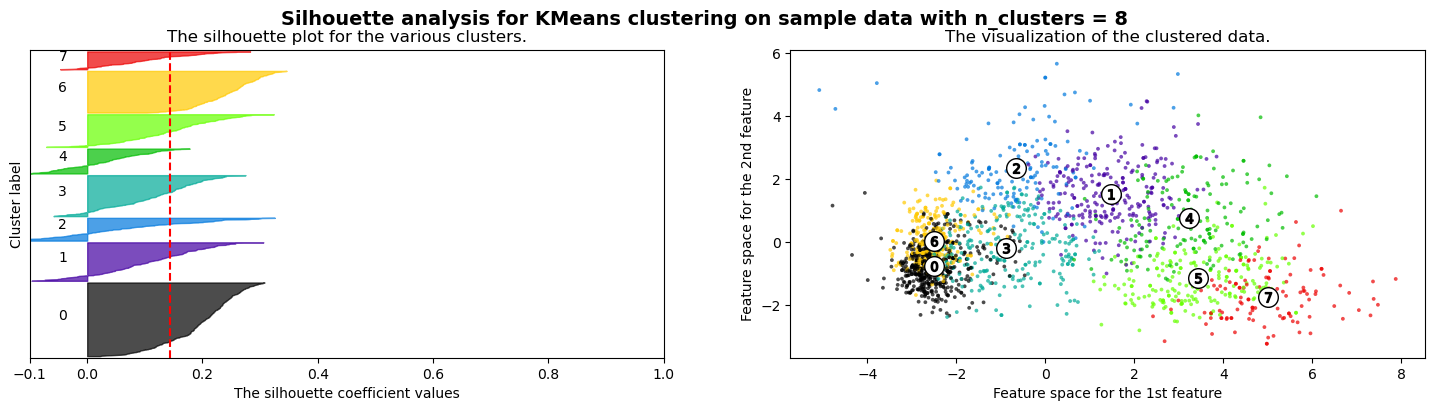

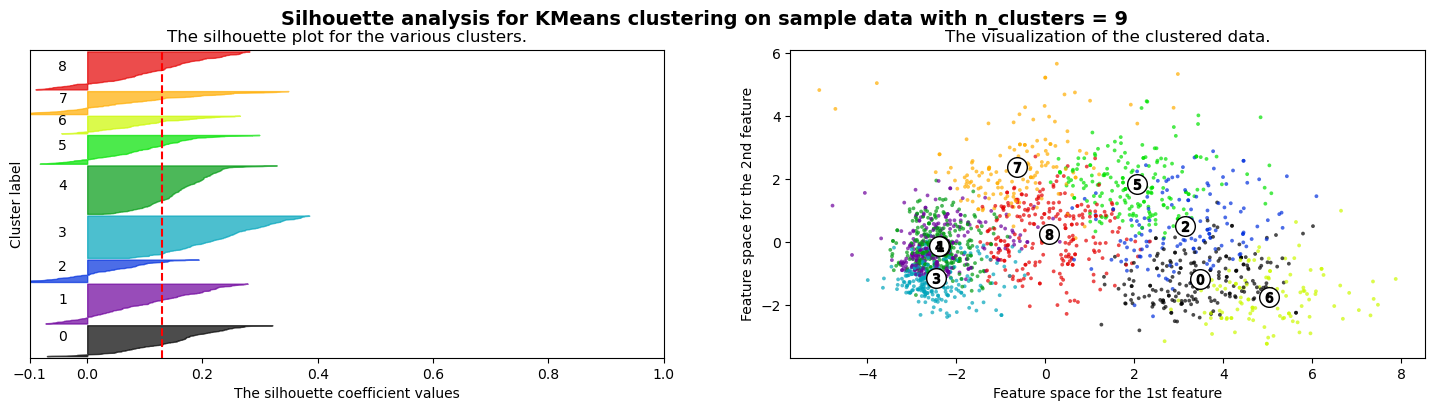

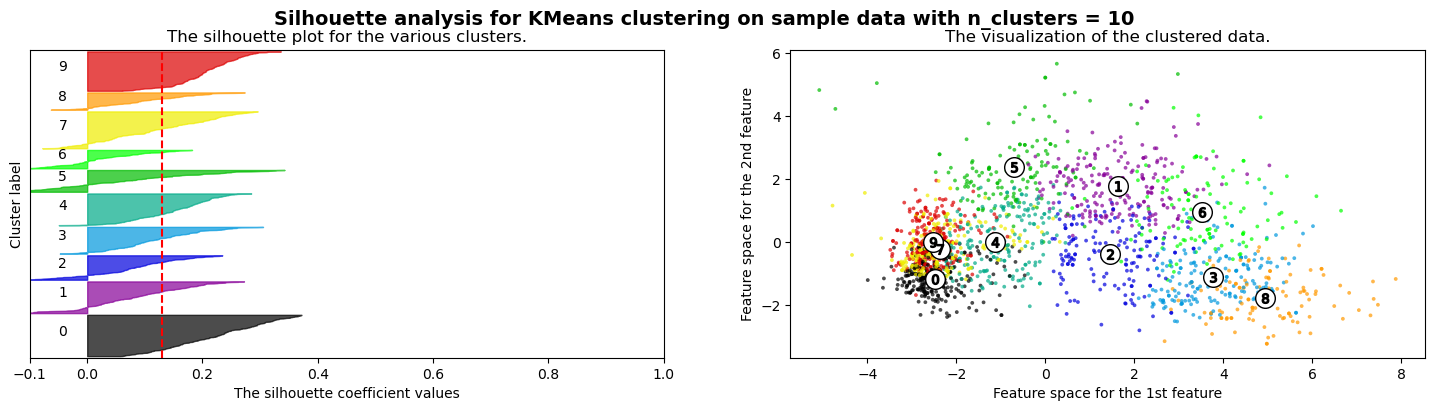

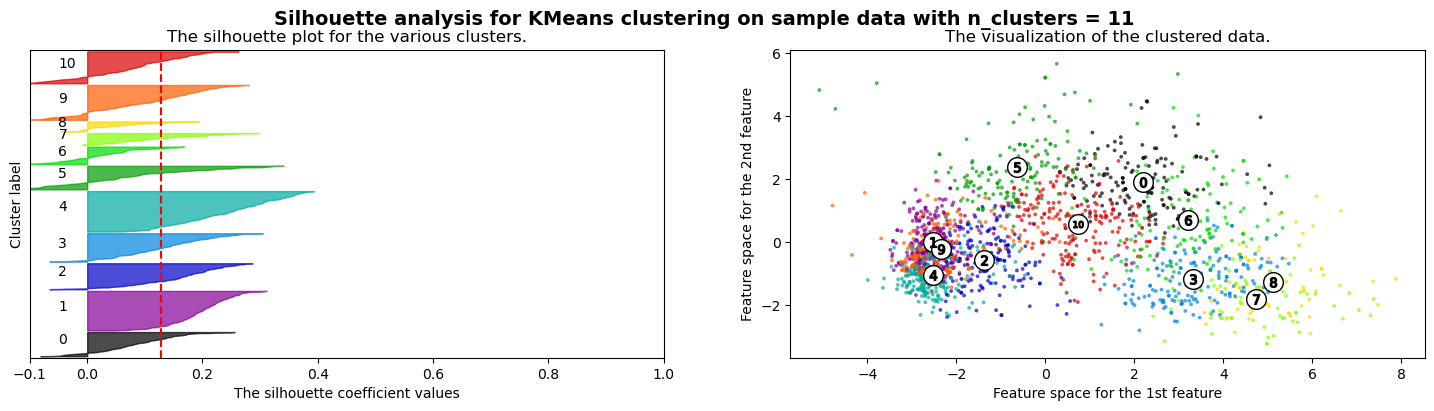

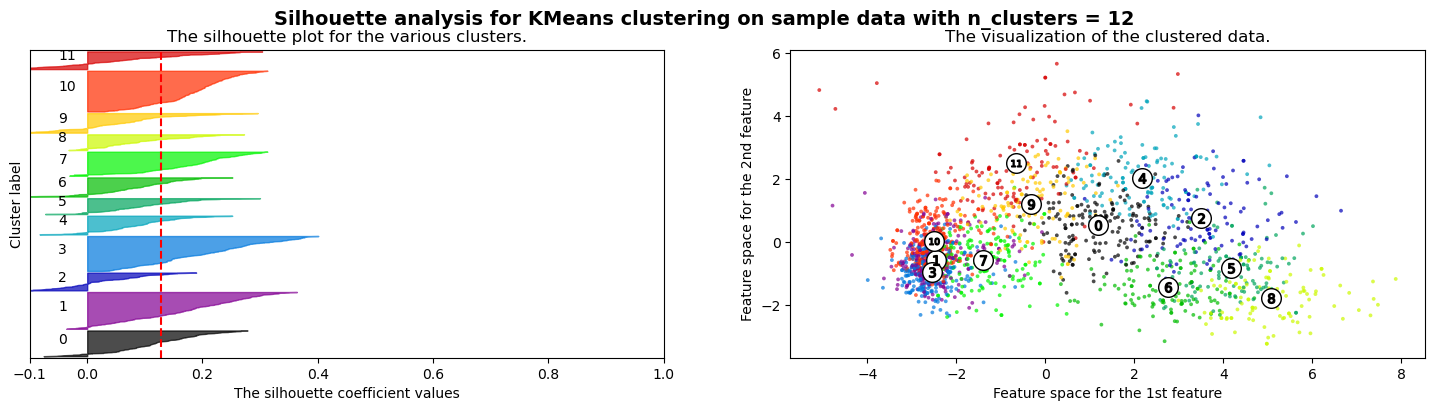

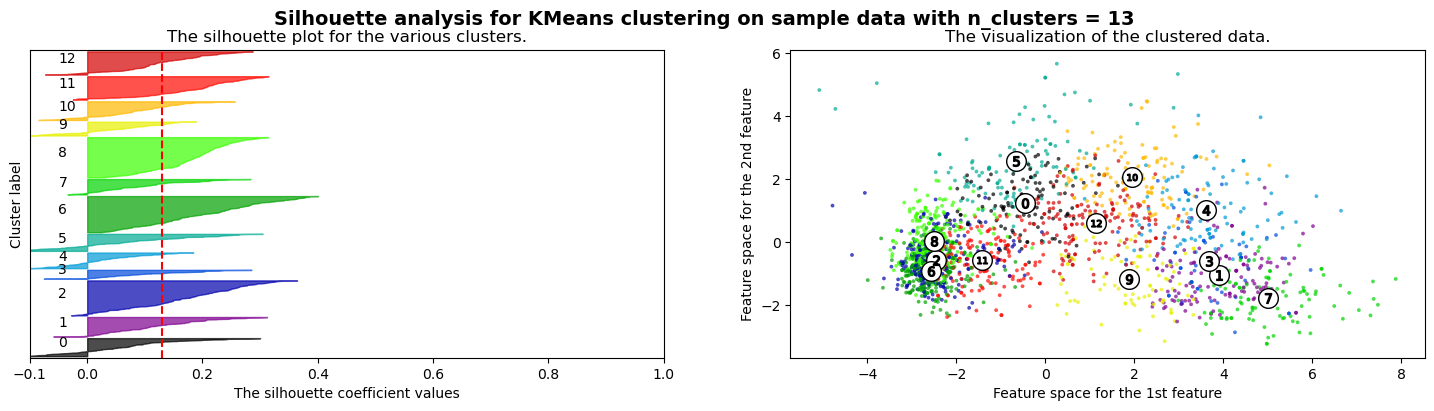

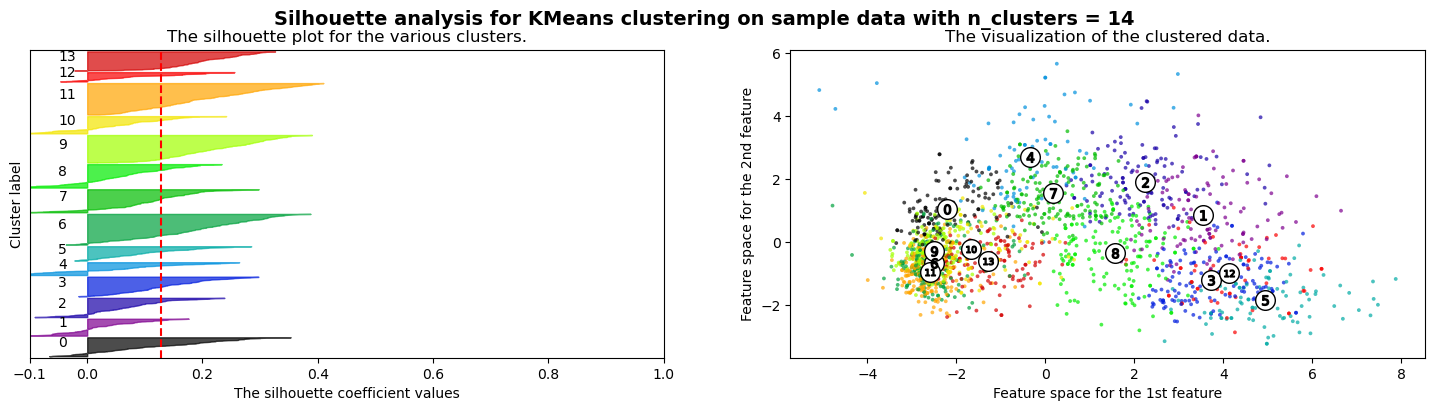

In [31]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), X_num_reduced, random_state)

In [32]:
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KModes(n_clusters = n_clusters, init = 'Huang', n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KModes clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.04261640872845499
For n_clusters = 3 The average silhouette_score is : 0.03848593260038687
For n_clusters = 4 The average silhouette_score is : -0.014629364826801217
For n_clusters = 5 The average silhouette_score is : -0.019340504799681146
For n_clusters = 6 The average silhouette_score is : -0.014028845792213387
For n_clusters = 7 The average silhouette_score is : -0.023444873081086906
For n_clusters = 8 The average silhouette_score is : -0.03442782615674485
For n_clusters = 9 The average silhouette_score is : -0.0610965326339501
For n_clusters = 10 The average silhouette_score is : -0.1273167592541258
For n_clusters = 11 The average silhouette_score is : -0.04650348280423385
For n_clusters = 12 The average silhouette_score is : -0.18424039354397428
For n_clusters = 13 The average silhouette_score is : -0.08073755946921636
For n_clusters = 14 The average silhouette_score is : -0.12323122609528762


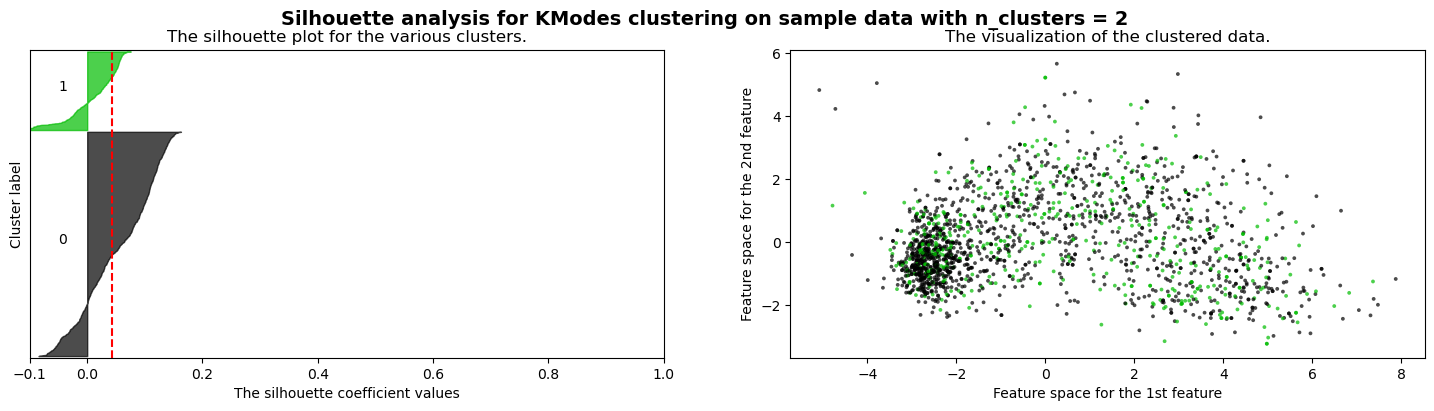

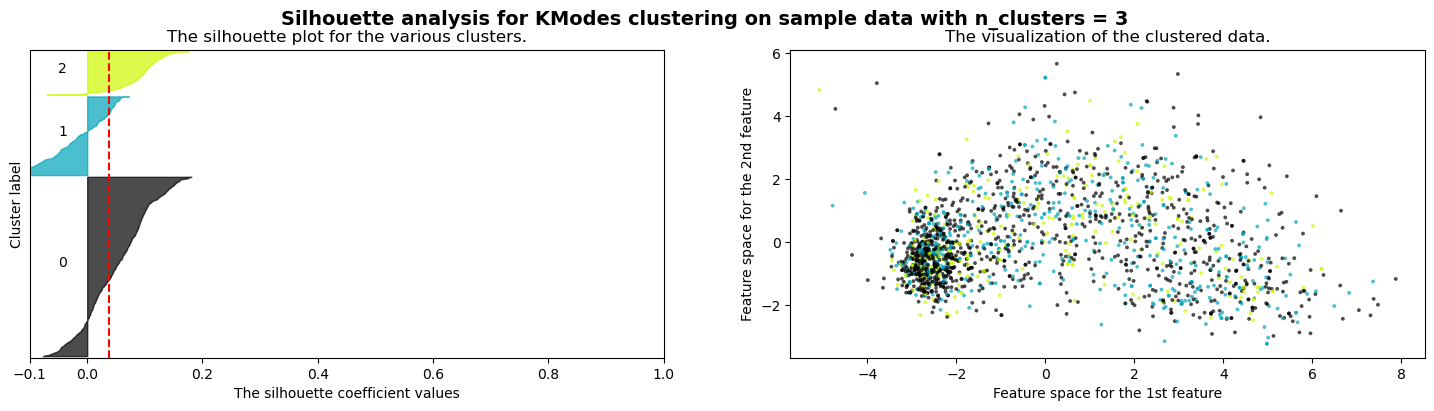

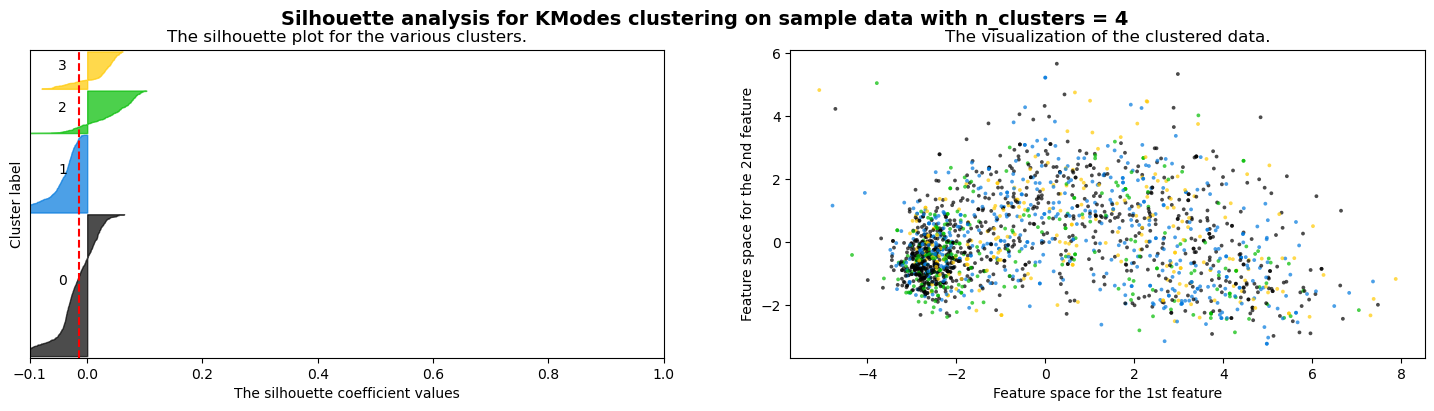

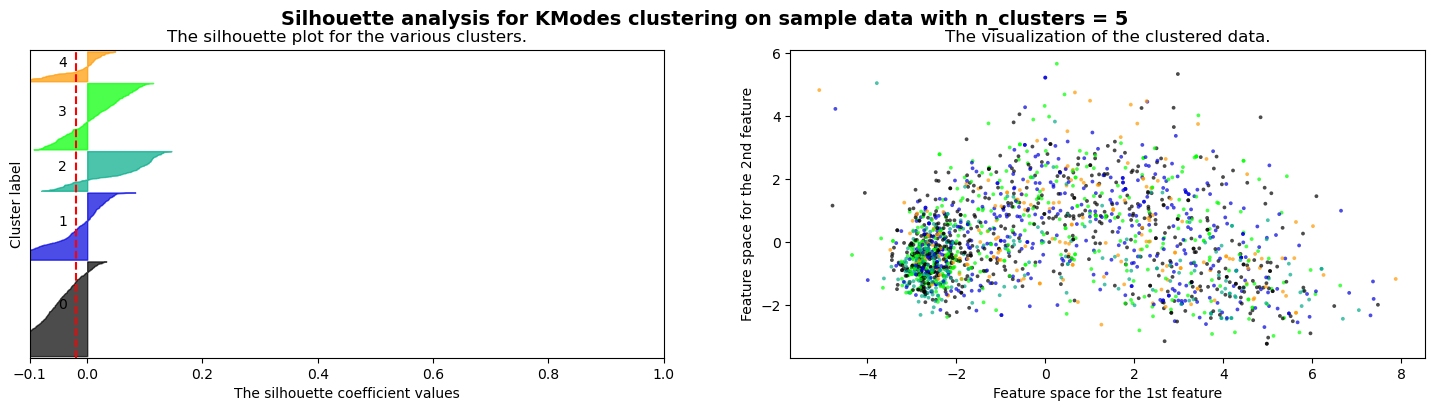

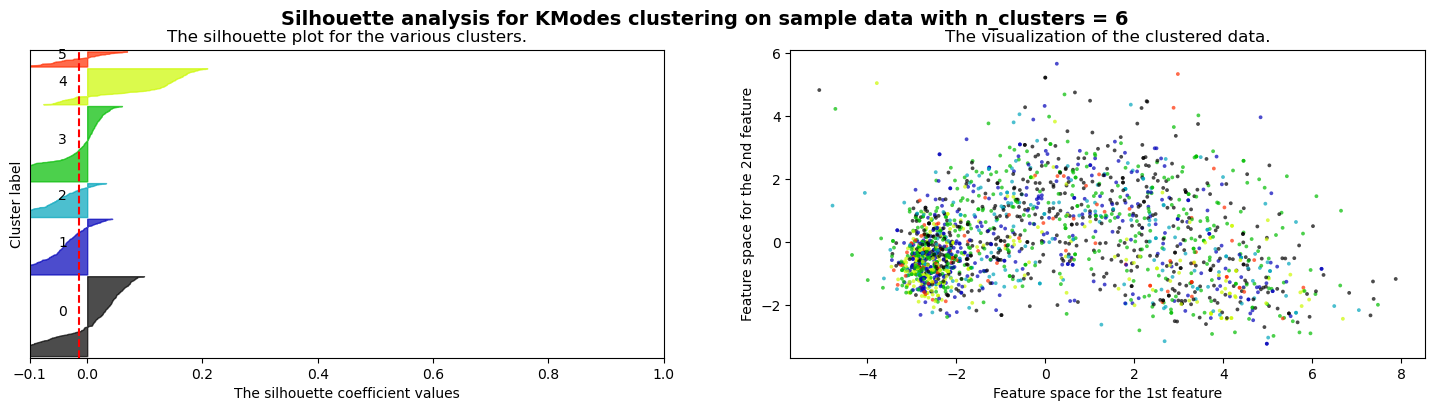

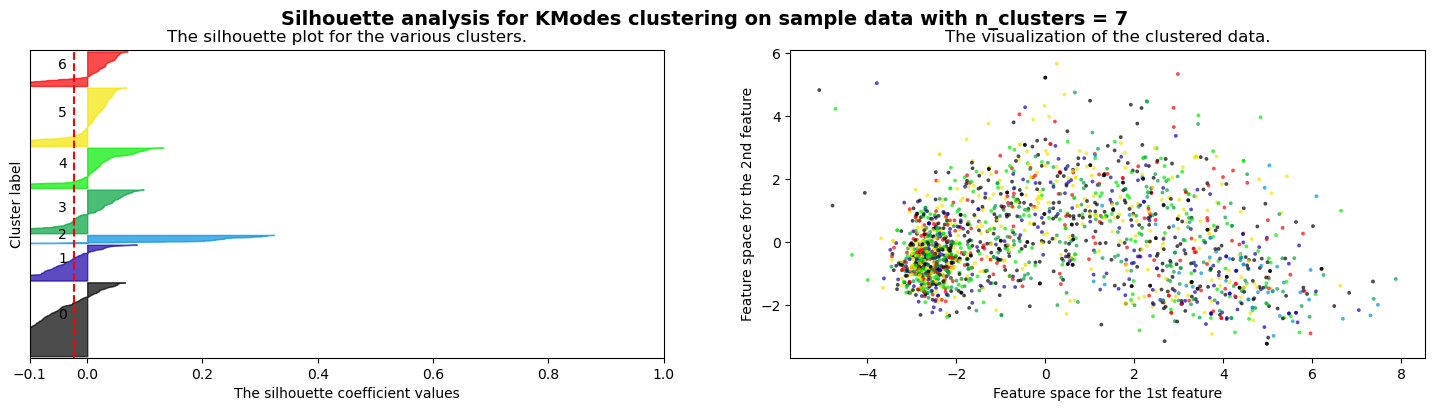

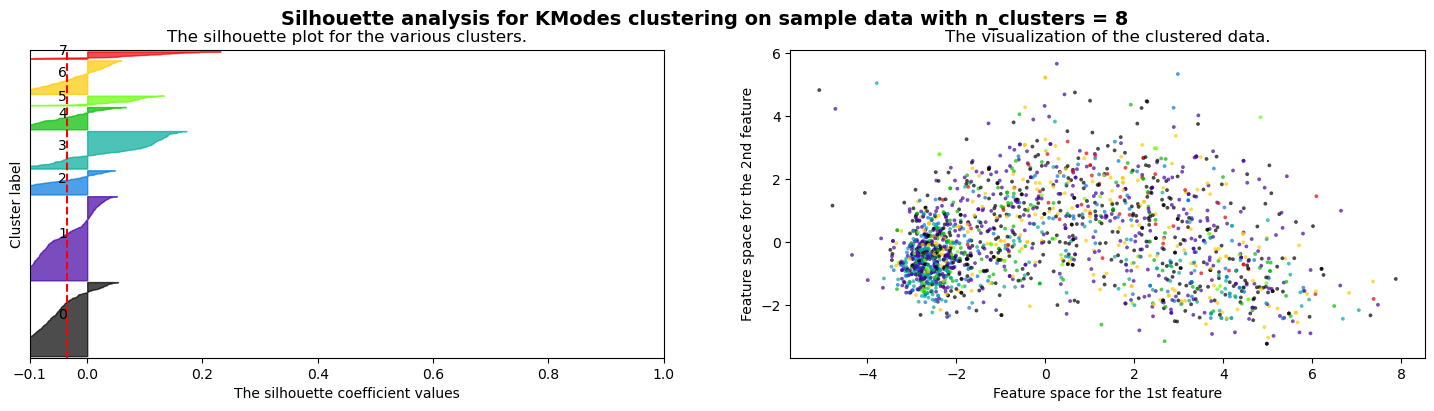

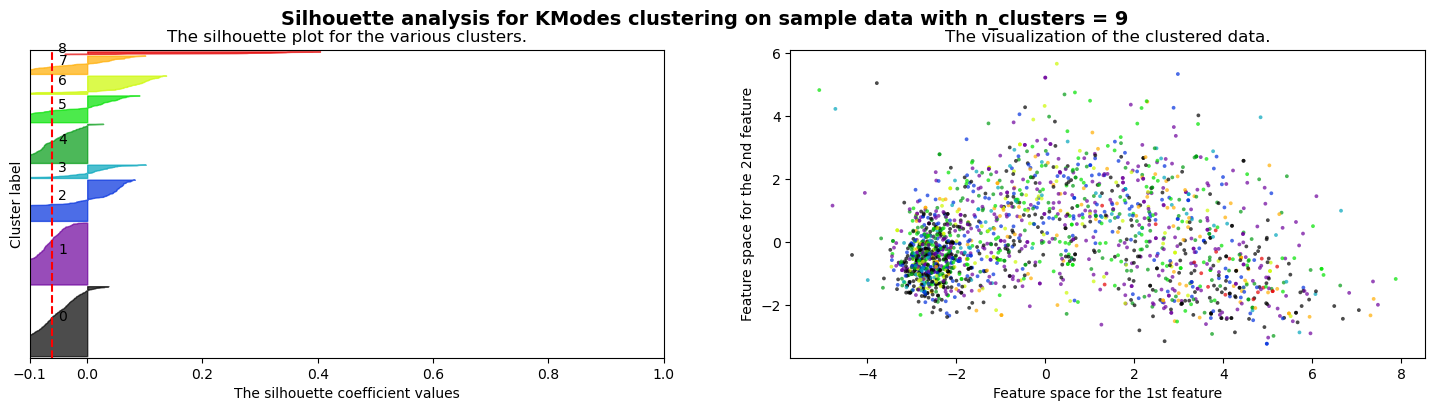

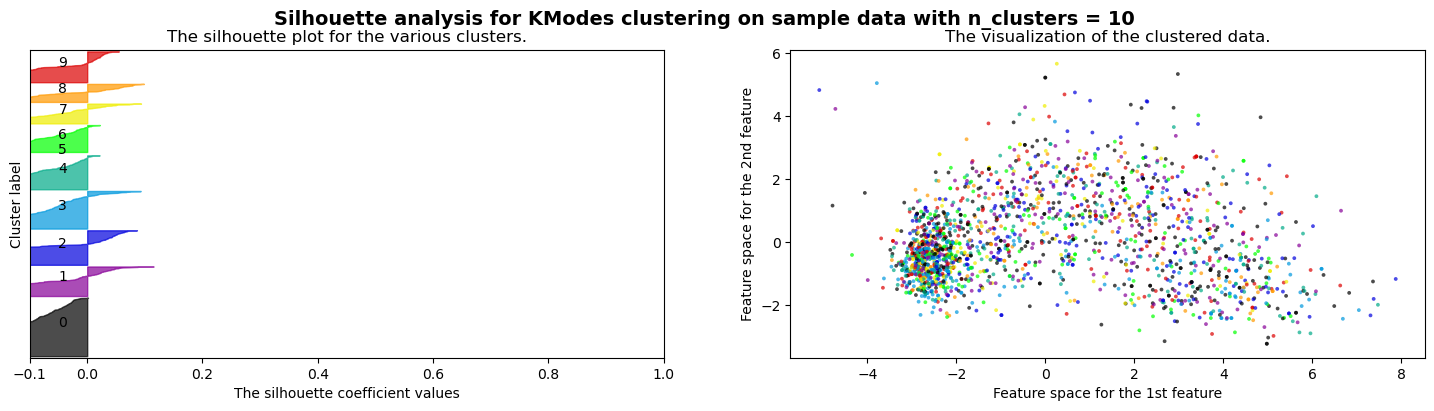

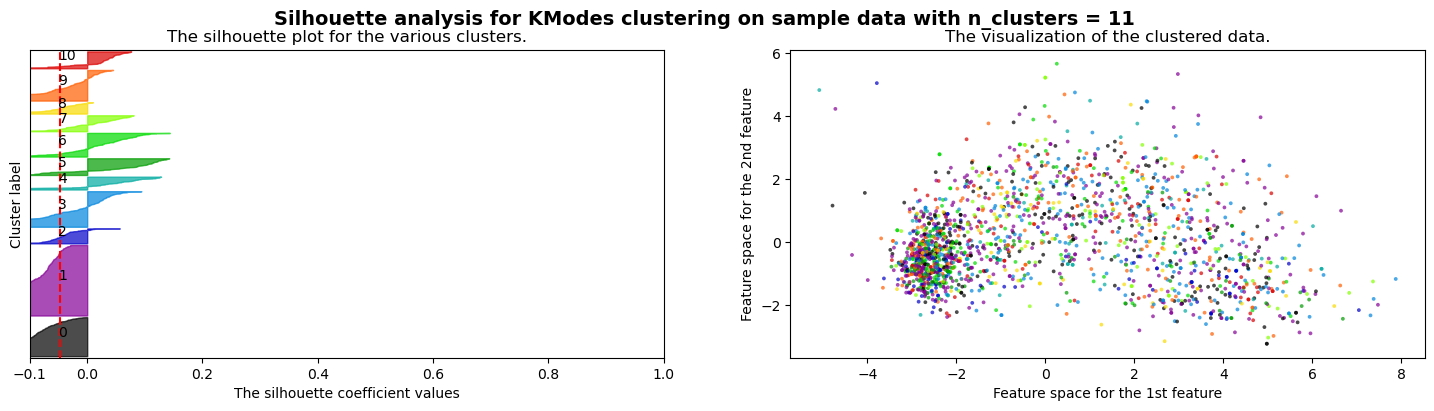

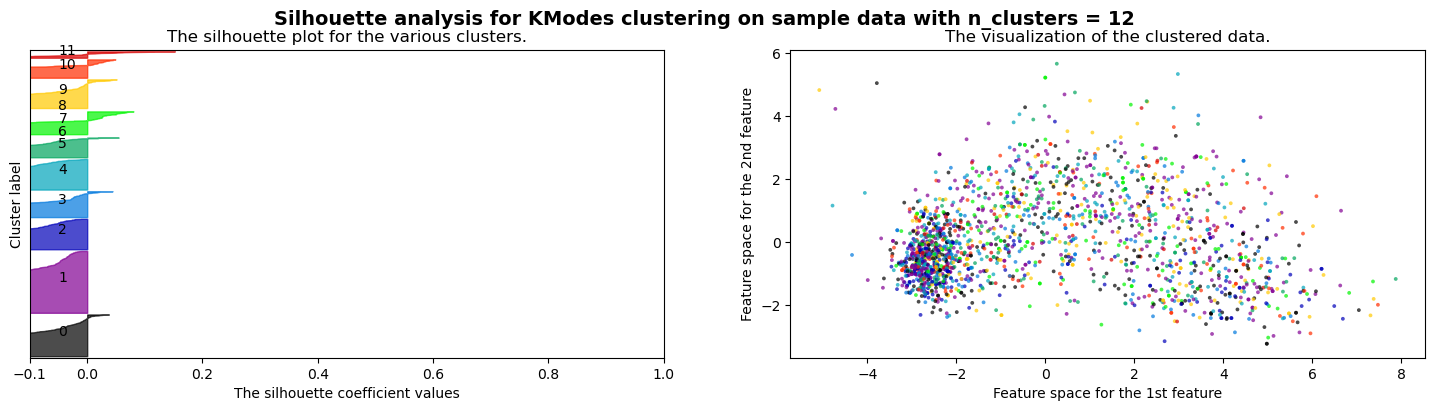

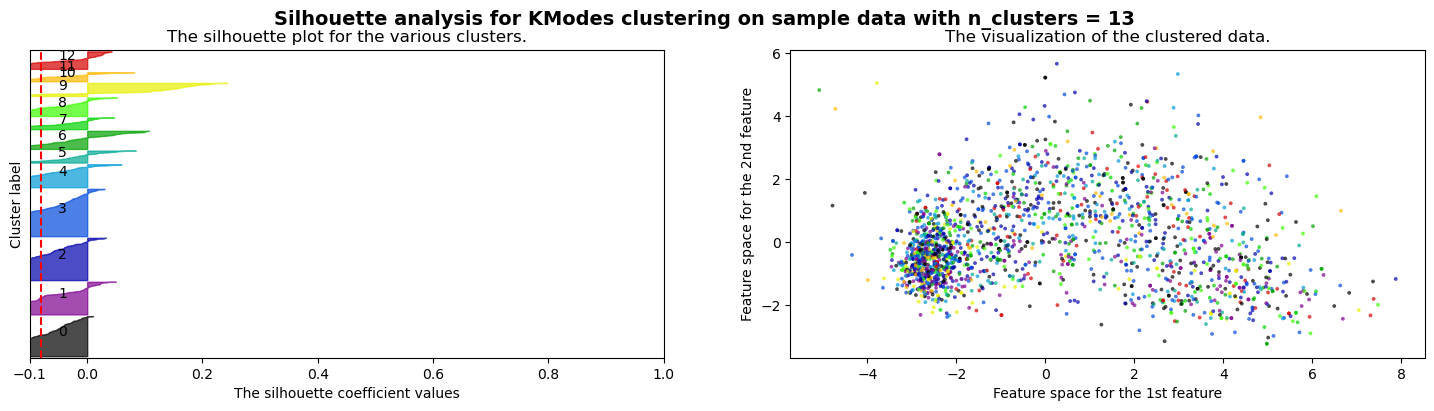

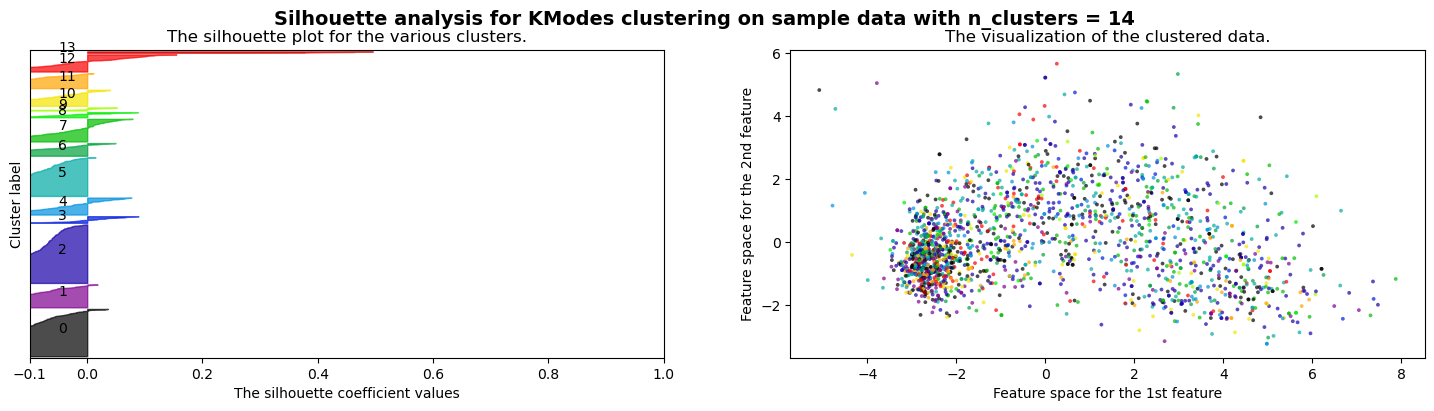

In [33]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), X_final, random_state)

In [34]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KPrototypes(n_clusters = n_clusters, init = 'Huang', n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X, categorical=[13, 14, 15, 16, 17, 18, 19, 20, 21])

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KPrototypes clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.28485531468763764
For n_clusters = 3 The average silhouette_score is : 0.2103692028182331
For n_clusters = 4 The average silhouette_score is : 0.11362679340932756
For n_clusters = 5 The average silhouette_score is : 0.1083813139629273
For n_clusters = 6 The average silhouette_score is : 0.10342304120997604
For n_clusters = 7 The average silhouette_score is : 0.10007333364503021
For n_clusters = 8 The average silhouette_score is : 0.09921612836149656
For n_clusters = 9 The average silhouette_score is : 0.09512963609471288
For n_clusters = 10 The average silhouette_score is : 0.09452832527072177
For n_clusters = 11 The average silhouette_score is : 0.07896111596152011
For n_clusters = 12 The average silhouette_score is : 0.08279105935808677
For n_clusters = 13 The average silhouette_score is : 0.07600492818333267
For n_clusters = 14 The average silhouette_score is : 0.0756876403471957


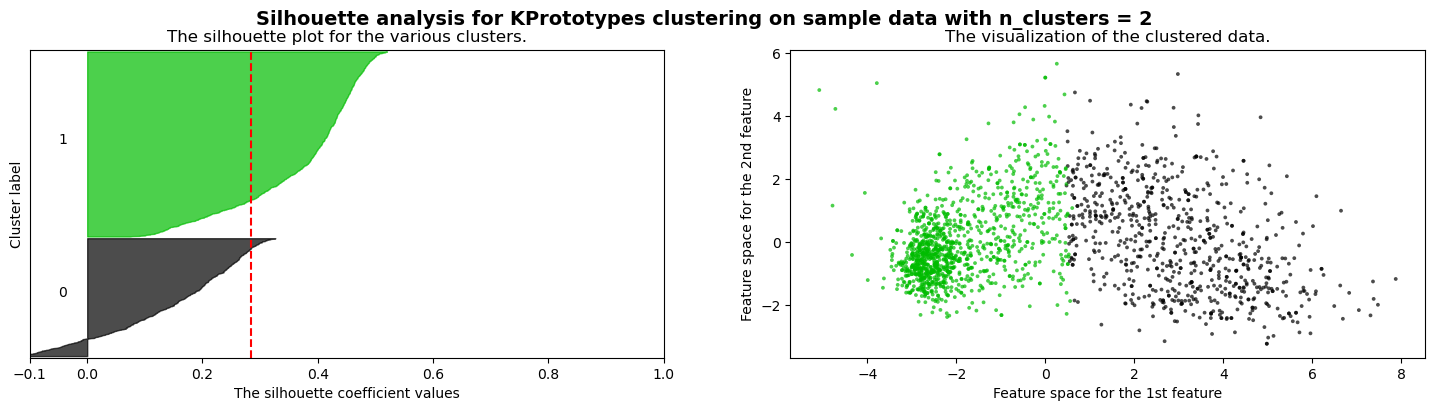

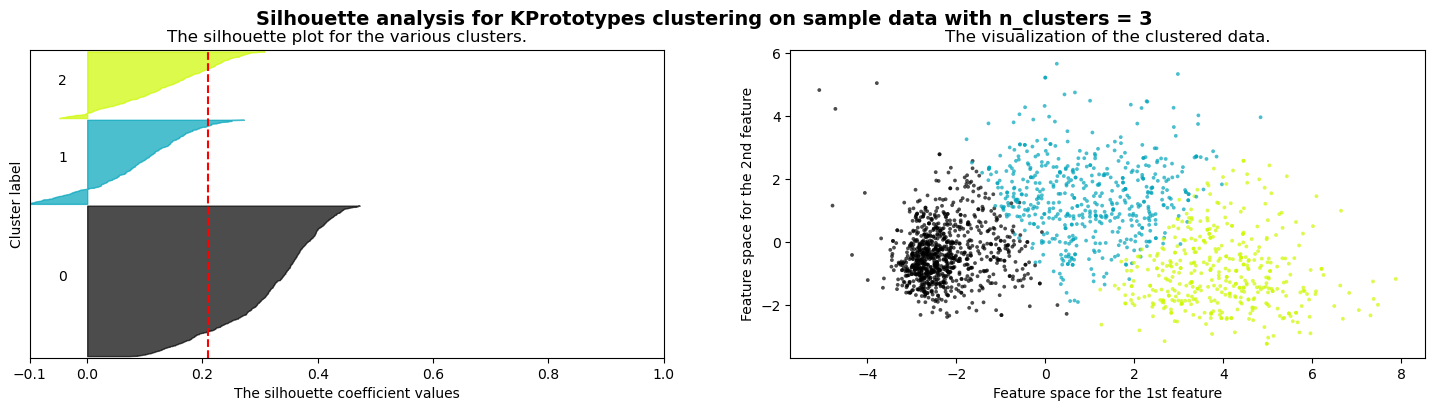

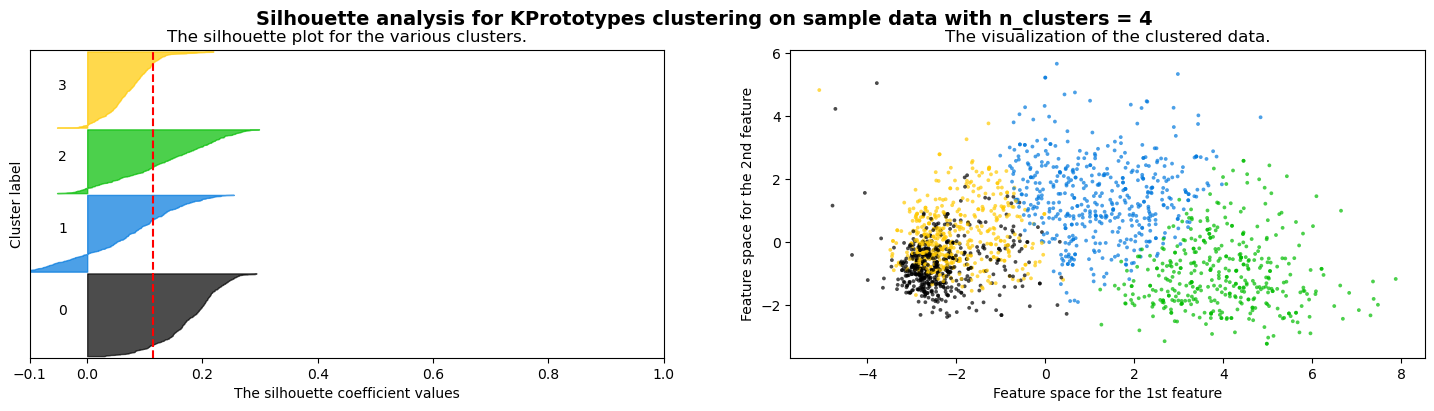

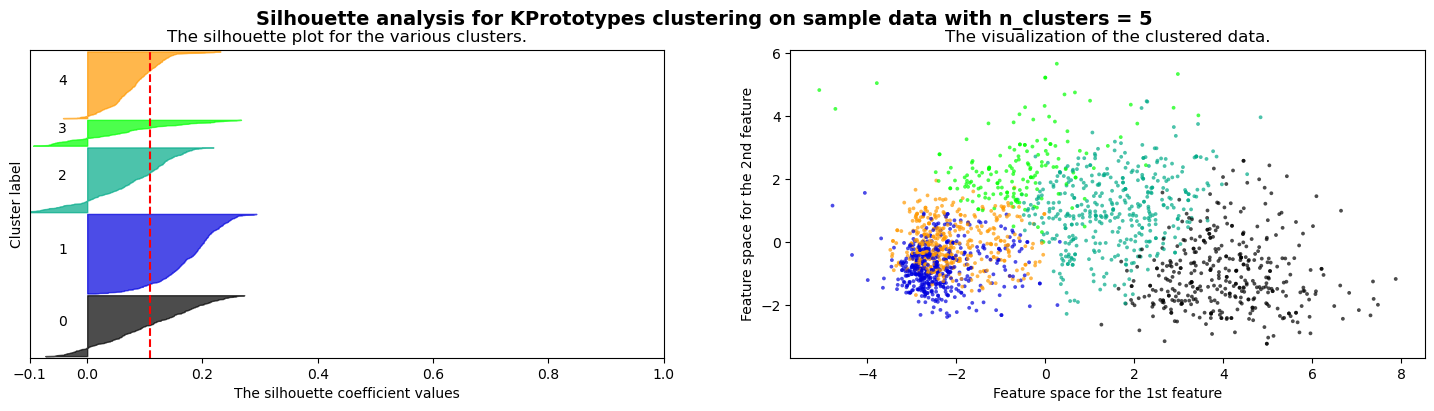

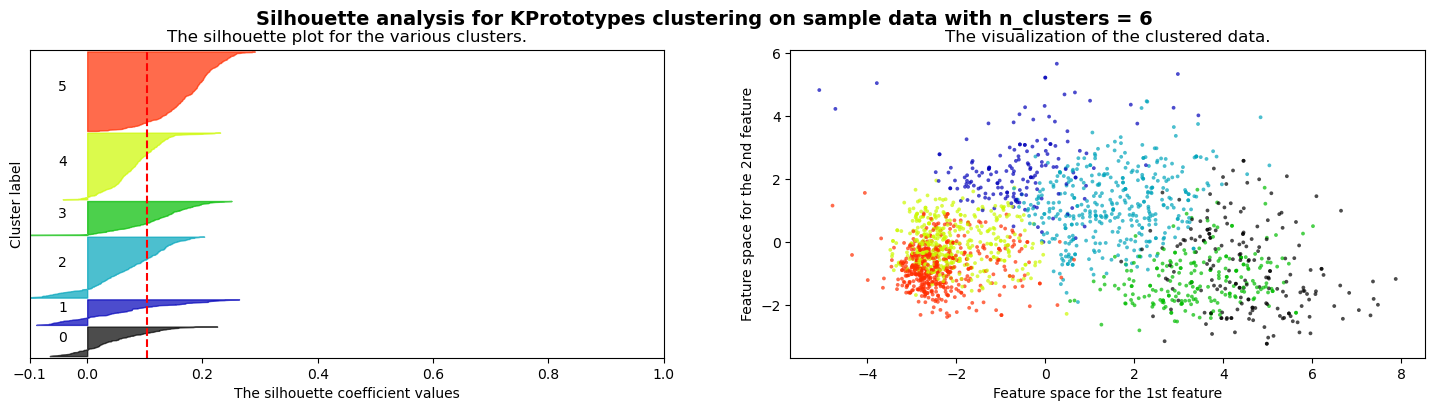

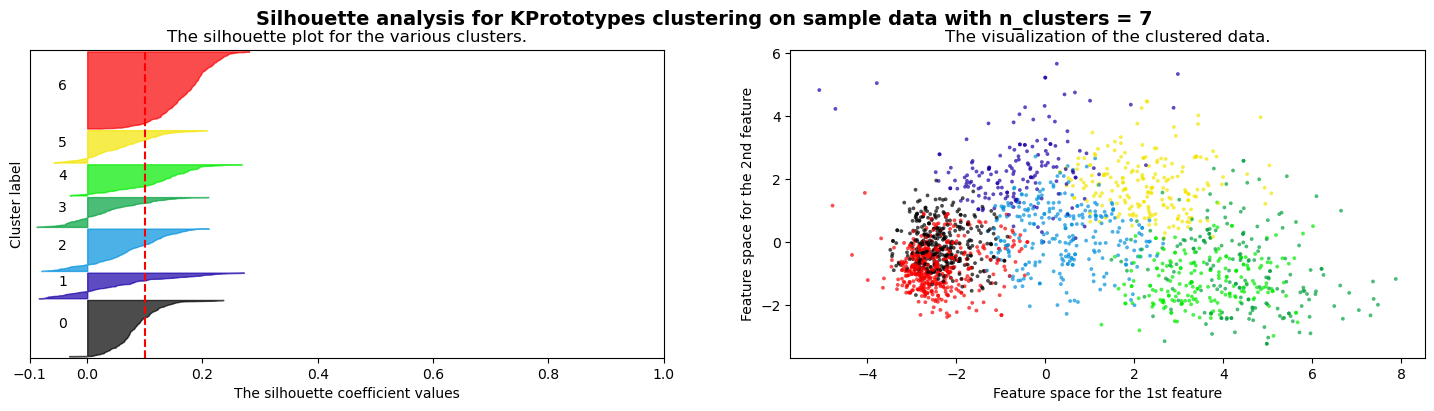

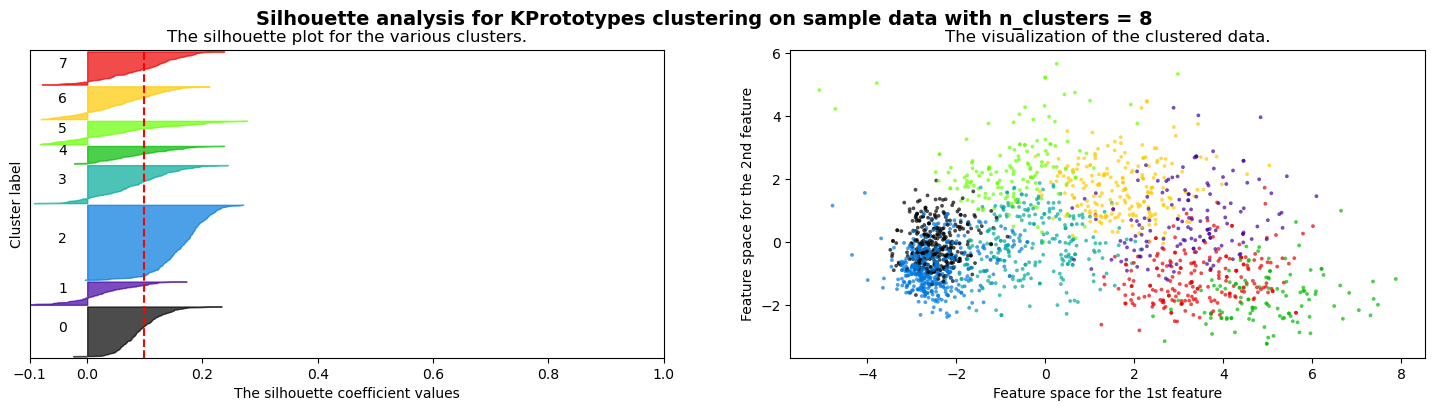

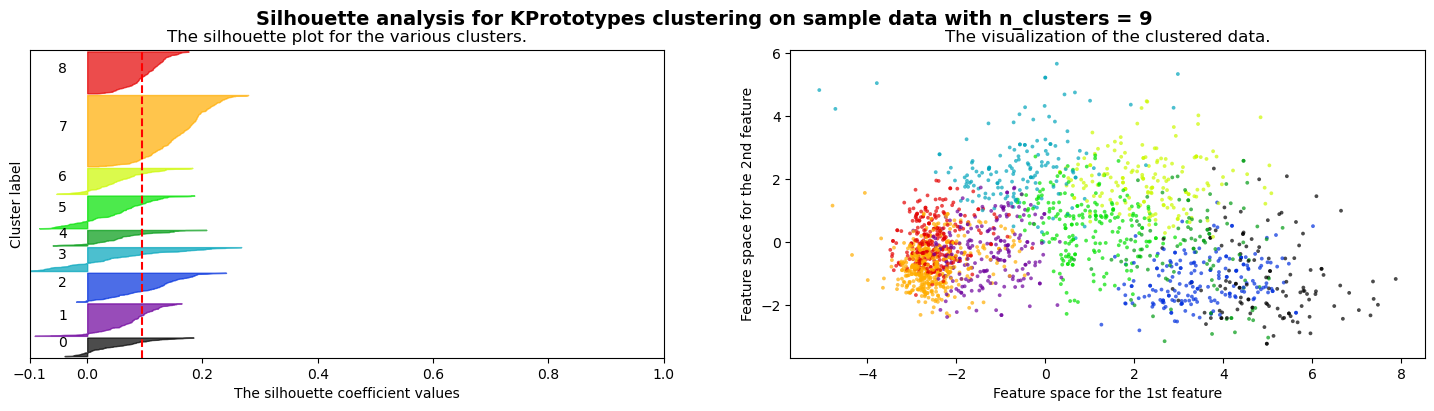

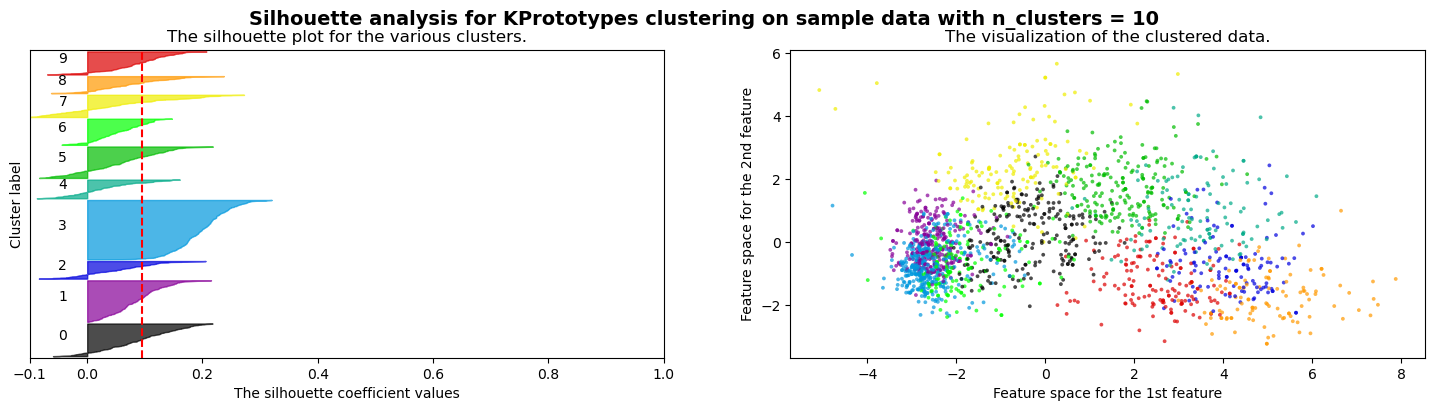

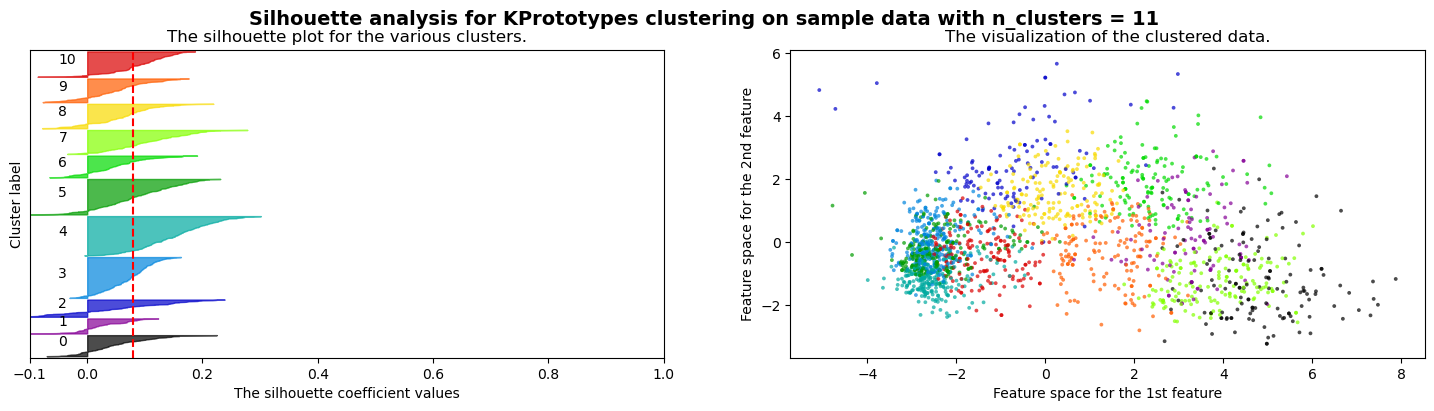

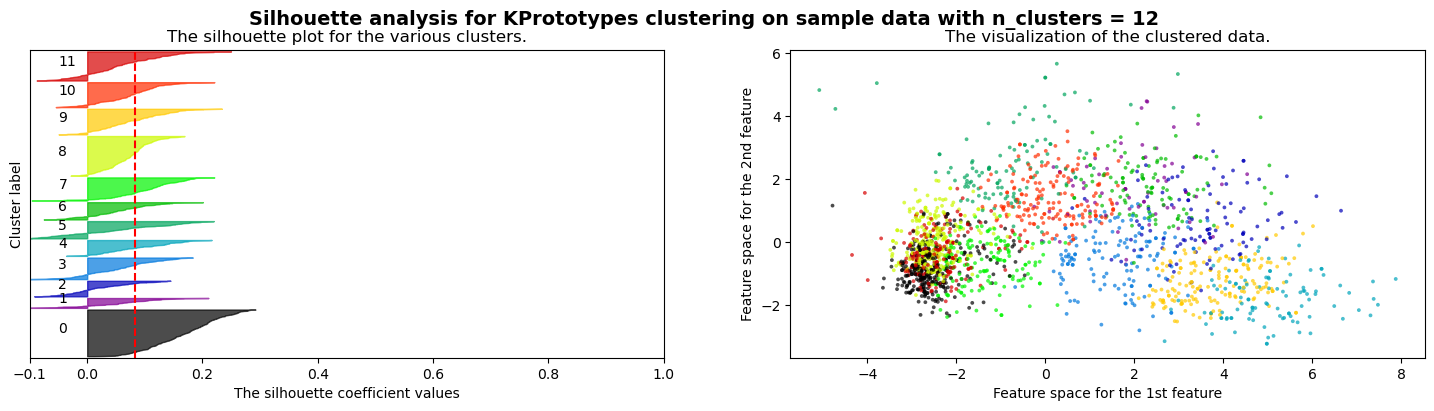

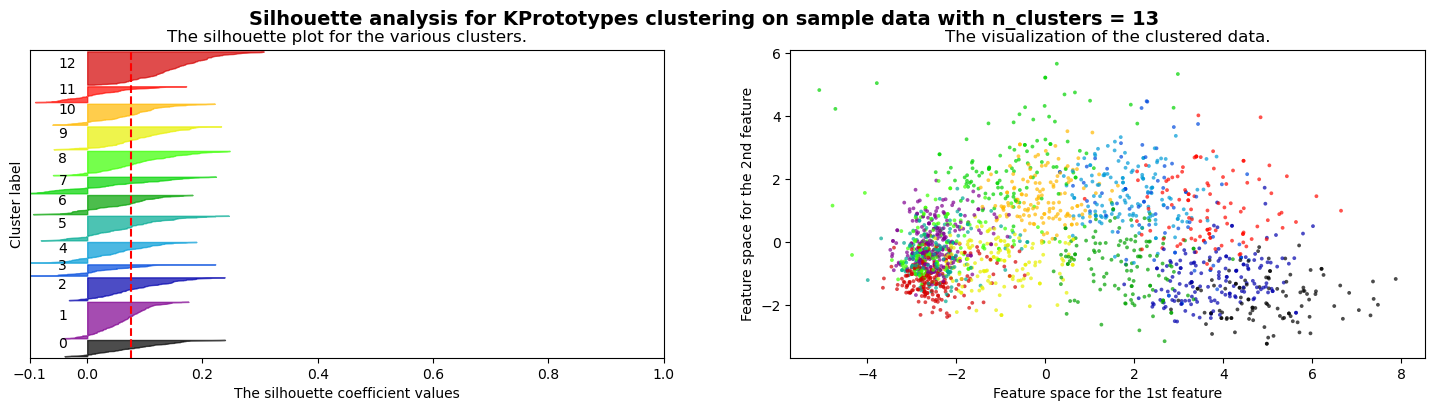

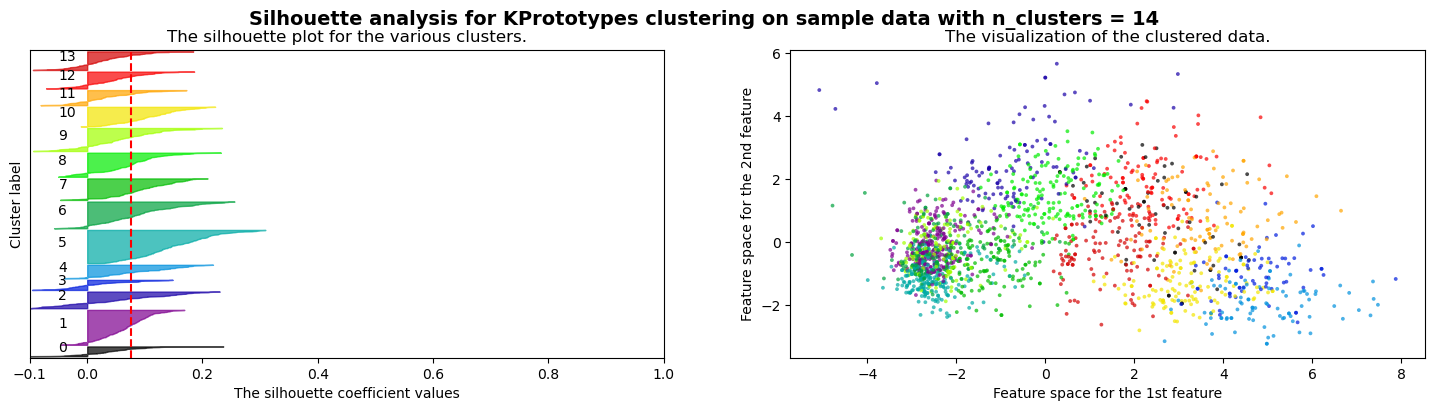

In [35]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), X_final, random_state)

## 2. Clustering

In [36]:
# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
random_state = 10
clusterer = KPrototypes(n_clusters = 3, init = 'Huang', n_init = 10, random_state = random_state)
cluster_labels = clusterer.fit_predict(X_final, categorical=[13, 14, 15, 16, 17, 18, 19, 20, 21])

In [37]:
# Add the cluster labels to the original DataFrame
df['Cluster_Labels'] = cluster_labels
df

year_birth   education marital_status   income  kidhome  teenhome  \
1           1954  Graduation         Single  46344.0        1         1   
2           1965  Graduation       Together  71613.0        0         0   
3           1984  Graduation       Together  26646.0        1         0   
4           1981         PhD        Married  58293.0        1         0   
5           1967      Master       Together  62513.0        0         1   
...          ...         ...            ...      ...      ...       ...   
2210        1974  Graduation        Married  34421.0        1         0   
2211        1967  Graduation        Married  61223.0        0         1   
2212        1946         PhD       Together  64014.0        2         1   
2213        1981  Graduation       Divorced  56981.0        0         0   
2214        1956      Master       Together  69245.0        0         1   

      recency  mnt_wines  mnt_fruits  mnt_meat_products  ...  accepted_cmp3  \
1          38         11           1                  6  ...              0   
2          26        426          49                127  ...              0   
3          26         11           4                 20  ...              0   
4          94        173          43                118  ...              0   
5          16        520          42                 98  ...              0   
...       ...        ...         ...                ...  ...            ...   
2210       81          3           3                  7  ...              0   
2211       46        709          43                182  ...              0   
2212       56        406           0                 30  ...              0   
2213       91        908          48                217  ...              0   
2214        8        428          30                214  ...              0   

      accepted_cmp4  accepted_cmp5  accepted_cmp1  accepted_cmp2  complain  \
1                 0              0              0              0         0   
2                 0              0              0              0         0   
3                 0              0              0              0         0   
4                 0              0              0              0         0   
5                 0              0              0              0         0   
...             ...            ...            ...            ...       ...   
2210              0              0              0              0         0   
2211              0              0              0              0         0   
2212              0              0              1              0         0   
2213              1              0              0              0         0   
2214              0              0              0              0         0   

      total_mnt    generation  customer_since  Cluster_Labels  
1            27  Baby Boomers             299               0  
2           776  Generation X             498               1  
3            53   Millennials             325               0  
4           422   Millennials             347               1  
5           716  Generation X             479               1  
...         ...           ...             ...             ...  
2210         30  Generation X             549               0  
2211       1341  Generation X             567               1  
2212        444  Baby Boomers             205               1  
2213       1241   Millennials             341               2  
2214        843  Baby Boomers             342               1  

[1872 rows x 28 columns]

# VI. Cluster Analysis

In [38]:
cluster0 = df[df['Cluster_Labels'] == 0]
cluster0.describe().T

count          mean           std     min      25%  \
year_birth             935.0   1971.207487     11.086759  1940.0   1964.0   
income                 935.0  34730.818182  12226.701361  1730.0  26187.0   
kidhome                935.0      0.774332      0.506261     0.0      0.0   
teenhome               935.0      0.471658      0.528623     0.0      0.0   
recency                935.0     51.129412     28.690651     0.0     27.0   
mnt_wines              935.0     42.517647     52.826181     0.0      8.0   
mnt_fruits             935.0      4.782888      7.483667     0.0      0.0   
mnt_meat_products      935.0     22.132620     23.696772     0.0      7.0   
mnt_fish_products      935.0      7.179679     11.946159     0.0      0.0   
mnt_sweet_products     935.0      4.858824      7.402280     0.0      0.0   
mnt_gold_prods         935.0     14.071658     17.811234     0.0      4.0   
num_deals_purchases    935.0      2.014973      1.411861     0.0      1.0   
num_web_purchases      935.0      2.067380      1.263368     0.0      1.0   
num_catalog_purchases  935.0      0.505882      0.707650     0.0      0.0   
num_store_purchases    935.0      3.287701      1.085040     0.0      3.0   
num_web_visits_month   935.0      6.370053      1.999990     1.0      5.0   
accepted_cmp3          935.0      0.047059      0.211878     0.0      0.0   
accepted_cmp4          935.0      0.013904      0.117154     0.0      0.0   
accepted_cmp5          935.0      0.000000      0.000000     0.0      0.0   
accepted_cmp1          935.0      0.000000      0.000000     0.0      0.0   
accepted_cmp2          935.0      0.002139      0.046225     0.0      0.0   
complain               935.0      0.010695      0.102918     0.0      0.0   
total_mnt              935.0     95.543316     85.807638     5.0     38.0   
customer_since         935.0    494.327273    195.383535   186.0    319.5   
Cluster_Labels         935.0      0.000000      0.000000     0.0      0.0   

                           50%      75%      max  
year_birth              1972.0   1979.0   1996.0  
income                 34587.0  43007.5  69139.0  
kidhome                    1.0      1.0      2.0  
teenhome                   0.0      1.0      2.0  
recency                   51.0     77.0     99.0  
mnt_wines                 22.0     55.5    308.0  
mnt_fruits                 2.0      6.0     58.0  
mnt_meat_products         14.0     26.0    171.0  
mnt_fish_products          3.0     10.0    150.0  
mnt_sweet_products         2.0      6.0     78.0  
mnt_gold_prods             9.0     18.0    262.0  
num_deals_purchases        2.0      3.0     15.0  
num_web_purchases          2.0      3.0      9.0  
num_catalog_purchases      0.0      1.0      5.0  
num_store_purchases        3.0      4.0      8.0  
num_web_visits_month       7.0      8.0     20.0  
accepted_cmp3              0.0      0.0      1.0  
accepted_cmp4              0.0      0.0      1.0  
accepted_cmp5              0.0      0.0      0.0  
accepted_cmp1              0.0      0.0      0.0  
accepted_cmp2              0.0      0.0      1.0  
complain                   0.0      0.0      1.0  
total_mnt                 62.0    129.0    415.0  
customer_since           479.0    657.0    883.0  
Cluster_Labels             0.0      0.0      0.0

In [39]:
cluster1 = df[df['Cluster_Labels'] == 1]
cluster1.describe().T

count          mean           std     min      25%  \
year_birth             523.0   1965.499044     10.135363  1943.0   1957.0   
income                 523.0  58464.040153  11073.984050  4428.0  51607.0   
kidhome                523.0      0.227533      0.446192     0.0      0.0   
teenhome               523.0      0.913958      0.440150     0.0      1.0   
recency                523.0     50.372849     27.800269     0.0     27.5   
mnt_wines              523.0    447.912046    264.924481     6.0    245.0   
mnt_fruits             523.0     22.432122     25.877487     0.0      5.0   
mnt_meat_products      523.0    133.149140     88.556910     3.0     70.0   
mnt_fish_products      523.0     30.359465     33.920021     0.0      7.0   
mnt_sweet_products     523.0     24.051625     30.468425     0.0      4.0   
mnt_gold_prods         523.0     60.453155     53.366506     0.0     21.0   
num_deals_purchases    523.0      3.596558      2.247124     0.0      2.0   
num_web_purchases      523.0      6.342256      2.644207     1.0      4.5   
num_catalog_purchases  523.0      3.003824      1.855918     0.0      2.0   
num_store_purchases    523.0      7.854685      2.677047     0.0      6.0   
num_web_visits_month   523.0      5.579350      1.890416     0.0      4.0   
accepted_cmp3          523.0      0.043977      0.205240     0.0      0.0   
accepted_cmp4          523.0      0.116635      0.321292     0.0      0.0   
accepted_cmp5          523.0      0.017208      0.130172     0.0      0.0   
accepted_cmp1          523.0      0.026769      0.161561     0.0      0.0   
accepted_cmp2          523.0      0.007648      0.087202     0.0      0.0   
complain               523.0      0.007648      0.087202     0.0      0.0   
total_mnt              523.0    718.357553    316.543473   232.0    458.0   
customer_since         523.0    576.445507    191.046790   186.0    444.0   
Cluster_Labels         523.0      1.000000      0.000000     1.0      1.0   

                           50%      75%       max  
year_birth              1966.0   1974.0    1992.0  
income                 58597.0  65506.0  113734.0  
kidhome                    0.0      0.0       2.0  
teenhome                   1.0      1.0       2.0  
recency                   52.0     72.0      99.0  
mnt_wines                391.0    599.0    1349.0  
mnt_fruits                14.0     32.0     142.0  
mnt_meat_products        113.0    171.0     650.0  
mnt_fish_products         19.0     45.0     223.0  
mnt_sweet_products        13.0     31.5     262.0  
mnt_gold_prods            42.0     87.0     321.0  
num_deals_purchases        3.0      5.0      15.0  
num_web_purchases          6.0      8.0      27.0  
num_catalog_purchases      3.0      4.0      11.0  
num_store_purchases        8.0     10.0      13.0  
num_web_visits_month       6.0      7.0       9.0  
accepted_cmp3              0.0      0.0       1.0  
accepted_cmp4              0.0      0.0       1.0  
accepted_cmp5              0.0      0.0       1.0  
accepted_cmp1              0.0      0.0       1.0  
accepted_cmp2              0.0      0.0       1.0  
complain                   0.0      0.0       1.0  
total_mnt                660.0    928.0    1829.0  
customer_since           582.0    739.5     881.0  
Cluster_Labels             1.0      1.0       1.0

In [40]:
cluster2 = df[df['Cluster_Labels'] == 2]
cluster2.describe().T

count          mean          std     min       25%  \
year_birth             414.0   1967.528986    13.126978  1941.0   1957.00   
income                 414.0  74219.538647  9352.224987  2447.0  68682.00   
kidhome                414.0      0.043478     0.204178     0.0      0.00   
teenhome               414.0      0.231884     0.433855     0.0      0.00   
recency                414.0     53.553140    28.810911     0.0     29.00   
mnt_wines              414.0    564.516908   291.302890     1.0    350.00   
mnt_fruits             414.0     70.968599    51.014706     0.0     28.00   
mnt_meat_products      414.0    425.985507   215.687694    74.0    259.00   
mnt_fish_products      414.0    104.929952    65.898134     0.0     50.00   
mnt_sweet_products     414.0     72.265700    52.342252     0.0     31.00   
mnt_gold_prods         414.0     77.234300    59.939927     0.0     31.25   
num_deals_purchases    414.0      1.371981     1.154751     0.0      1.00   
num_web_purchases      414.0      5.079710     2.195290     0.0      3.25   
num_catalog_purchases  414.0      5.772947     2.474400     2.0      4.00   
num_store_purchases    414.0      8.777778     2.859738     0.0      6.00   
num_web_visits_month   414.0      2.722222     1.702480     0.0      1.00   
accepted_cmp3          414.0      0.045894     0.209508     0.0      0.00   
accepted_cmp4          414.0      0.067633     0.251419     0.0      0.00   
accepted_cmp5          414.0      0.147343     0.354876     0.0      0.00   
accepted_cmp1          414.0      0.118357     0.323422     0.0      0.00   
accepted_cmp2          414.0      0.009662     0.097937     0.0      0.00   
complain               414.0      0.007246     0.084919     0.0      0.00   
total_mnt              414.0   1315.900966   381.178766   421.0   1027.50   
customer_since         414.0    519.934783   203.796148   187.0    347.50   
Cluster_Labels         414.0      2.000000     0.000000     2.0      2.00   

                           50%       75%      max  
year_birth              1968.0   1978.00   1995.0  
income                 74561.0  80386.25  98777.0  
kidhome                    0.0      0.00      1.0  
teenhome                   0.0      0.00      2.0  
recency                   56.0     78.75     99.0  
mnt_wines                510.5    757.50   1493.0  
mnt_fruits                61.0    107.00    199.0  
mnt_meat_products        398.0    553.75   1725.0  
mnt_fish_products         94.0    150.75    259.0  
mnt_sweet_products        58.0    107.00    197.0  
mnt_gold_prods            57.0    108.00    249.0  
num_deals_purchases        1.0      1.00     15.0  
num_web_purchases          5.0      6.00     11.0  
num_catalog_purchases      5.0      7.00     28.0  
num_store_purchases        9.0     11.00     13.0  
num_web_visits_month       2.0      4.00      8.0  
accepted_cmp3              0.0      0.00      1.0  
accepted_cmp4              0.0      0.00      1.0  
accepted_cmp5              0.0      0.00      1.0  
accepted_cmp1              0.0      0.00      1.0  
accepted_cmp2              0.0      0.00      1.0  
complain                   0.0      0.00      1.0  
total_mnt               1282.5   1573.75   2525.0  
customer_since           495.5    691.75    884.0  
Cluster_Labels             2.0      2.00      2.0

# VII. Model Saving

In [41]:
df.to_csv('data_clustered.csv', index = False)

In [42]:
# Save the trained KNN model
with open('Streamlit\\clustering_model.pkl', 'wb') as f:
    pickle.dump(clusterer, f)

# Save the fitted StandardScaler
with open('Streamlit\\clustering_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the fitted PCA
with open('Streamlit\\pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

# Combine the lists into a dictionary
columns = {'num_col': X_num.columns.to_list(), 'cat_col': X_cat.columns.to_list()}

# Write the dictionary to a text file in JSON format
with open('Streamlit\\clustering_columns.txt', 'w') as f:
    json.dump(columns, f)

# ?. Coba

In [43]:
# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
random_state = 10
clusterer = KPrototypes(n_clusters = 4, init = 'Huang', n_init = 10, random_state = random_state)
cluster_labels = clusterer.fit_predict(X_final, categorical=[13, 14, 15, 16, 17, 18, 19, 20, 21])

In [44]:
# Add the cluster labels to the original DataFrame
df['Cluster_Labels'] = cluster_labels
df

year_birth   education marital_status   income  kidhome  teenhome  \
1           1954  Graduation         Single  46344.0        1         1   
2           1965  Graduation       Together  71613.0        0         0   
3           1984  Graduation       Together  26646.0        1         0   
4           1981         PhD        Married  58293.0        1         0   
5           1967      Master       Together  62513.0        0         1   
...          ...         ...            ...      ...      ...       ...   
2210        1974  Graduation        Married  34421.0        1         0   
2211        1967  Graduation        Married  61223.0        0         1   
2212        1946         PhD       Together  64014.0        2         1   
2213        1981  Graduation       Divorced  56981.0        0         0   
2214        1956      Master       Together  69245.0        0         1   

      recency  mnt_wines  mnt_fruits  mnt_meat_products  ...  accepted_cmp3  \
1          38         11           1                  6  ...              0   
2          26        426          49                127  ...              0   
3          26         11           4                 20  ...              0   
4          94        173          43                118  ...              0   
5          16        520          42                 98  ...              0   
...       ...        ...         ...                ...  ...            ...   
2210       81          3           3                  7  ...              0   
2211       46        709          43                182  ...              0   
2212       56        406           0                 30  ...              0   
2213       91        908          48                217  ...              0   
2214        8        428          30                214  ...              0   

      accepted_cmp4  accepted_cmp5  accepted_cmp1  accepted_cmp2  complain  \
1                 0              0              0              0         0   
2                 0              0              0              0         0   
3                 0              0              0              0         0   
4                 0              0              0              0         0   
5                 0              0              0              0         0   
...             ...            ...            ...            ...       ...   
2210              0              0              0              0         0   
2211              0              0              0              0         0   
2212              0              0              1              0         0   
2213              1              0              0              0         0   
2214              0              0              0              0         0   

      total_mnt    generation  customer_since  Cluster_Labels  
1            27  Baby Boomers             299               3  
2           776  Generation X             498               1  
3            53   Millennials             325               0  
4           422   Millennials             347               1  
5           716  Generation X             479               1  
...         ...           ...             ...             ...  
2210         30  Generation X             549               0  
2211       1341  Generation X             567               1  
2212        444  Baby Boomers             205               3  
2213       1241   Millennials             341               1  
2214        843  Baby Boomers             342               1  

[1872 rows x 28 columns]

In [45]:
cluster0 = df[df['Cluster_Labels'] == 0]
cluster0.mean(numeric_only=True).T

year_birth                1976.704062
income                   29645.901354
kidhome                      0.793037
teenhome                     0.005803
recency                     51.794971
mnt_wines                   33.452611
mnt_fruits                   6.446809
mnt_meat_products           25.268859
mnt_fish_products           10.075435
mnt_sweet_products           6.638298
mnt_gold_prods              16.359768
num_deals_purchases          1.787234
num_web_purchases            2.152805
num_catalog_purchases        0.481625
num_store_purchases          3.218569
num_web_visits_month         6.781431
accepted_cmp3                0.046422
accepted_cmp4                0.003868
accepted_cmp5                0.000000
accepted_cmp1                0.000000
accepted_cmp2                0.000000
complain                     0.009671
total_mnt                   98.241779
customer_since             513.015474
Cluster_Labels               0.000000
dtype: float64

Cluster 0: Low-income Families.

- relatively low income and spending
- have one or more small children at home
- low campaigns acceptance
- have been customers for a long time, but recency is average.

kesimpulan: price-sensitive and look for deals and discounts when shopping.

In [46]:
cluster1 = df[df['Cluster_Labels'] == 1]
cluster1.mean(numeric_only=True).T

year_birth                1965.785417
income                   59707.481250
kidhome                      0.191667
teenhome                     0.889583
recency                     49.677083
mnt_wines                  487.816667
mnt_fruits                  24.858333
mnt_meat_products          143.518750
mnt_fish_products           33.172917
mnt_sweet_products          25.606250
mnt_gold_prods              64.050000
num_deals_purchases          3.508333
num_web_purchases            6.529167
num_catalog_purchases        3.202083
num_store_purchases          8.222917
num_web_visits_month         5.493750
accepted_cmp3                0.047917
accepted_cmp4                0.120833
accepted_cmp5                0.020833
accepted_cmp1                0.022917
accepted_cmp2                0.008333
complain                     0.008333
total_mnt                  779.022917
customer_since             578.206250
Cluster_Labels               1.000000
dtype: float64

Cluster 1: Mid-Aged Moderate Spenders.

- relatively high income and spending
- have no small children at home, but may have teenagers
- higher acceptance rates for campaigns
- have been customers for a shorter time than Cluster 0, but recency is similar.

kesimpulan: less price-sensitive and more quality-oriented when shopping.

In [47]:
cluster2 = df[df['Cluster_Labels'] == 2]
cluster2.mean(numeric_only=True).T

year_birth                1967.571429
income                   74396.298246
kidhome                      0.040100
teenhome                     0.220551
recency                     54.020050
mnt_wines                  557.964912
mnt_fruits                  71.639098
mnt_meat_products          433.674185
mnt_fish_products          106.270677
mnt_sweet_products          73.844612
mnt_gold_prods              77.824561
num_deals_purchases          1.345865
num_web_purchases            5.025063
num_catalog_purchases        5.819549
num_store_purchases          8.726817
num_web_visits_month         2.664160
accepted_cmp3                0.047619
accepted_cmp4                0.067669
accepted_cmp5                0.150376
accepted_cmp1                0.122807
accepted_cmp2                0.010025
complain                     0.007519
total_mnt                 1321.218045
customer_since             519.290727
Cluster_Labels               2.000000
dtype: float64

Cluster 2: High-end Shoppers.

- have the highest income and spending
- have no children at home
- have the highest acceptance rates for campaigns
- have been customers for the shortest time, but their recency is the highest.

kesimpulan: They are likely to be very quality-oriented and prefer premium products and services.

In [48]:
cluster3 = df[df['Cluster_Labels'] == 3]
cluster3.mean(numeric_only=True).T

year_birth                1964.281513
income                   42240.025210
kidhome                      0.720588
teenhome                     1.044118
recency                     50.724790
mnt_wines                   70.686975
mnt_fruits                   3.647059
mnt_meat_products           24.579832
mnt_fish_products            5.247899
mnt_sweet_products           3.892857
mnt_gold_prods              13.644958
num_deals_purchases          2.495798
num_web_purchases            2.313025
num_catalog_purchases        0.684874
num_store_purchases          3.619748
num_web_visits_month         5.871849
accepted_cmp3                0.042017
accepted_cmp4                0.031513
accepted_cmp5                0.000000
accepted_cmp1                0.006303
accepted_cmp2                0.004202
complain                     0.010504
total_mnt                  121.699580
customer_since             481.018908
Cluster_Labels               3.000000
dtype: float64

Cluster 3: Middle-income Parents.

- have moderate income and spending
- have both small children and teenagers at home.
- have average acceptance rates for campaigns 
- have been customers for a longer time than Cluster 1 and 2, but their recency is similar.

kesimpulan: They are likely to be somewhat price-sensitive and quality-oriented when shopping.

# ?. Coba 2

In [49]:
# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
random_state = 10
clusterer = KPrototypes(n_clusters = 5, init = 'Huang', n_init = 10, random_state = random_state)
cluster_labels = clusterer.fit_predict(X_final, categorical=[13, 14, 15, 16, 17, 18, 19, 20, 21])

In [50]:
# Add the cluster labels to the original DataFrame
df['Cluster_Labels'] = cluster_labels
df

year_birth   education marital_status   income  kidhome  teenhome  \
1           1954  Graduation         Single  46344.0        1         1   
2           1965  Graduation       Together  71613.0        0         0   
3           1984  Graduation       Together  26646.0        1         0   
4           1981         PhD        Married  58293.0        1         0   
5           1967      Master       Together  62513.0        0         1   
...          ...         ...            ...      ...      ...       ...   
2210        1974  Graduation        Married  34421.0        1         0   
2211        1967  Graduation        Married  61223.0        0         1   
2212        1946         PhD       Together  64014.0        2         1   
2213        1981  Graduation       Divorced  56981.0        0         0   
2214        1956      Master       Together  69245.0        0         1   

      recency  mnt_wines  mnt_fruits  mnt_meat_products  ...  accepted_cmp3  \
1          38         11           1                  6  ...              0   
2          26        426          49                127  ...              0   
3          26         11           4                 20  ...              0   
4          94        173          43                118  ...              0   
5          16        520          42                 98  ...              0   
...       ...        ...         ...                ...  ...            ...   
2210       81          3           3                  7  ...              0   
2211       46        709          43                182  ...              0   
2212       56        406           0                 30  ...              0   
2213       91        908          48                217  ...              0   
2214        8        428          30                214  ...              0   

      accepted_cmp4  accepted_cmp5  accepted_cmp1  accepted_cmp2  complain  \
1                 0              0              0              0         0   
2                 0              0              0              0         0   
3                 0              0              0              0         0   
4                 0              0              0              0         0   
5                 0              0              0              0         0   
...             ...            ...            ...            ...       ...   
2210              0              0              0              0         0   
2211              0              0              0              0         0   
2212              0              0              1              0         0   
2213              1              0              0              0         0   
2214              0              0              0              0         0   

      total_mnt    generation  customer_since  Cluster_Labels  
1            27  Baby Boomers             299               4  
2           776  Generation X             498               2  
3            53   Millennials             325               1  
4           422   Millennials             347               3  
5           716  Generation X             479               2  
...         ...           ...             ...             ...  
2210         30  Generation X             549               1  
2211       1341  Generation X             567               2  
2212        444  Baby Boomers             205               3  
2213       1241   Millennials             341               2  
2214        843  Baby Boomers             342               2  

[1872 rows x 28 columns]

In [51]:
cluster0 = df[df['Cluster_Labels'] == 0]
cluster0.mean(numeric_only=True).T

year_birth                1968.023499
income                   74505.193211
kidhome                      0.041775
teenhome                     0.211488
recency                     54.193211
mnt_wines                  554.221932
mnt_fruits                  73.195822
mnt_meat_products          442.104439
mnt_fish_products          108.963446
mnt_sweet_products          75.668407
mnt_gold_prods              78.138381
num_deals_purchases          1.362924
num_web_purchases            5.041775
num_catalog_purchases        5.864230
num_store_purchases          8.712794
num_web_visits_month         2.660574
accepted_cmp3                0.044386
accepted_cmp4                0.060052
accepted_cmp5                0.151436
accepted_cmp1                0.122715
accepted_cmp2                0.010444
complain                     0.007833
total_mnt                 1332.292428
customer_since             521.890339
Cluster_Labels               0.000000
dtype: float64

In [52]:
cluster1 = df[df['Cluster_Labels'] == 1]
cluster1.mean(numeric_only=True).T

year_birth                1976.568
income                   29442.424
kidhome                      0.794
teenhome                     0.006
recency                     51.522
mnt_wines                   29.988
mnt_fruits                   6.140
mnt_meat_products           22.904
mnt_fish_products            9.454
mnt_sweet_products           6.070
mnt_gold_prods              15.754
num_deals_purchases          1.658
num_web_purchases            2.060
num_catalog_purchases        0.446
num_store_purchases          3.172
num_web_visits_month         6.720
accepted_cmp3                0.046
accepted_cmp4                0.004
accepted_cmp5                0.000
accepted_cmp1                0.000
accepted_cmp2                0.000
complain                     0.010
total_mnt                   90.310
customer_since             508.106
Cluster_Labels               1.000
dtype: float64

In [53]:
cluster2 = df[df['Cluster_Labels'] == 2]
cluster2.mean(numeric_only=True).T

year_birth                1964.987715
income                   62043.968059
kidhome                      0.081081
teenhome                     0.874693
recency                     49.373464
mnt_wines                  521.122850
mnt_fruits                  27.422604
mnt_meat_products          152.923833
mnt_fish_products           35.120393
mnt_sweet_products          26.769042
mnt_gold_prods              63.648649
num_deals_purchases          2.690418
num_web_purchases            6.353808
num_catalog_purchases        3.491400
num_store_purchases          8.594595
num_web_visits_month         4.985258
accepted_cmp3                0.049140
accepted_cmp4                0.130221
accepted_cmp5                0.029484
accepted_cmp1                0.027027
accepted_cmp2                0.009828
complain                     0.009828
total_mnt                  827.007371
customer_since             551.565111
Cluster_Labels               2.000000
dtype: float64

In [54]:
cluster3 = df[df['Cluster_Labels'] == 3]
cluster3.mean(numeric_only=True).T

year_birth                1968.239264
income                   48399.834356
kidhome                      0.797546
teenhome                     0.852761
recency                     53.030675
mnt_wines                  273.092025
mnt_fruits                  11.736196
mnt_meat_products           92.766871
mnt_fish_products           19.809816
mnt_sweet_products          16.006135
mnt_gold_prods              49.079755
num_deals_purchases          6.208589
num_web_purchases            5.877301
num_catalog_purchases        1.846626
num_store_purchases          5.754601
num_web_visits_month         7.380368
accepted_cmp3                0.055215
accepted_cmp4                0.067485
accepted_cmp5                0.000000
accepted_cmp1                0.024540
accepted_cmp2                0.000000
complain                     0.000000
total_mnt                  462.490798
customer_since             649.754601
Cluster_Labels               3.000000
dtype: float64

In [55]:
cluster3 = df[df['Cluster_Labels'] == 4]
cluster3.mean(numeric_only=True).T

year_birth                1964.157518
income                   41477.632458
kidhome                      0.680191
teenhome                     1.040573
recency                     50.276850
mnt_wines                   56.921241
mnt_fruits                   3.357995
mnt_meat_products           20.405728
mnt_fish_products            4.890215
mnt_sweet_products           3.627685
mnt_gold_prods              12.028640
num_deals_purchases          2.088305
num_web_purchases            2.023866
num_catalog_purchases        0.579952
num_store_purchases          3.477327
num_web_visits_month         5.704057
accepted_cmp3                0.040573
accepted_cmp4                0.031026
accepted_cmp5                0.000000
accepted_cmp1                0.002387
accepted_cmp2                0.004773
complain                     0.011933
total_mnt                  101.231504
customer_since             464.429594
Cluster_Labels               4.000000
dtype: float64